# 14进阶3-实战：实战：构建一个支持复杂学术论文问答的RAG系统

>在前面的课程中，我们学习了 RAG 相关的知识，以及如何自定义 Reader 组件和在 RAG 任务中处理图片和表格数据。本节内容将在此基础上，利用前面学到的知识，搭建一个基于论文的问答系统。

在信息爆炸的时代，科研论文的数量激增，研究人员在查阅文献时面临诸多挑战。论文内容专业性强、逻辑复杂，传统的关键词检索方式难以精准提取核心信息，导致获取有效内容的成本较高。为了解决这一问题，RAG技术被广泛应用，RAG不仅能结合了检索能力，可以精准检索相关论文，还能结合大语言模型（LLM）的生成能力，对提问进行智能解析，提供深入、清晰的答案，帮助研究人员高效理解论文内容，提高科研效率。

本教程主要介绍如何利用 LazyLLM 搭建一个基于 RAG 的论文问答系统。为了实现该系统，我们需要为RAG准备并接入一个便于处理论文的解析器以及存储解析结果及向量化结果的数据存储器。让我们开始吧！

# **传统RAG的论文系统**

## 环境准备

如果您的电脑上安装了Python，请通过下方命令安装lazyllm及必要的依赖包。关于 LazyLLM 的环境更详细的准备可以参考《基础1-实战：最基础的RAG》中对应的内容。

In [ ]:
pip install lazyllm

## 设计方案

### 整体架构

为了方便我们查阅论文或者快速了解相关论文的核心内容，我们可以用 RAG 设计一个论文问答系统。这个问答系统我们采用的是 Retrieve-and-rerank 架构，来保证检索内容的准确性以及生成结果的合理性。

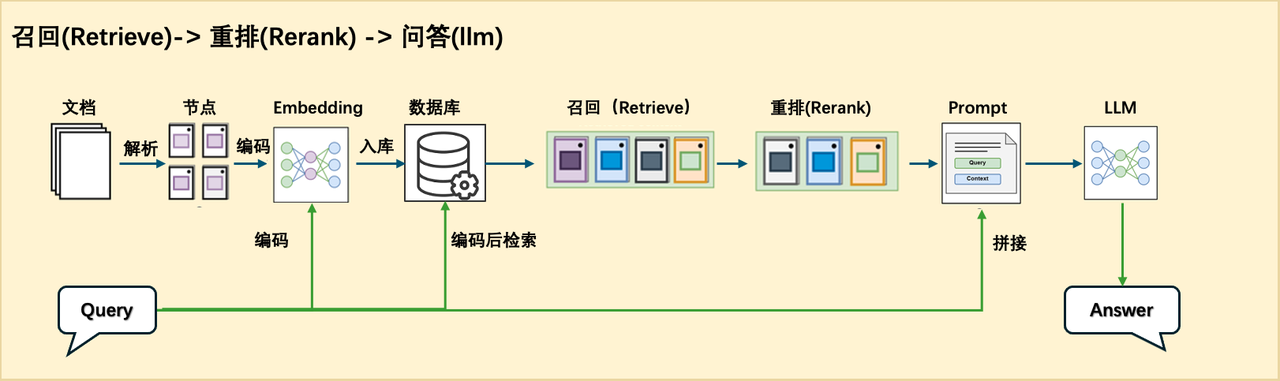

这个框架中首先把所有需要处理的论文进行预处理，切分成 chunks，然后经过 embedding 模型，把相应的文本和对应的 embedding 存放到数据库中，这一步属于离线部分。这一步处理完成后，就可以进行在线处理了。当提问的 query 来到之后先经过 embedding 模型，生成对应的 embedding 向量，然后使用这个 quey 和对应的 embedding 在数据库中进行检索，检索出相关的文本段出来，用于后面的处理。这一步属于粗筛，只要检索出相关的文本段即可，所以这里可以有基于关键字的检索，也可以有基于语义的检索方法。为了使传给大模型的相关上下文更精准，我们还要对检索到的这些文本段进行一下精排，即 Rerank。Rerank 可以把多种检索策略下检索到的文本段在统一空间中进行比较，然后返回相似度最高 K 个，然后和前面的 query 一起拼接在一个给大模型做最后的结果生成。

### 方案流程

综上所述，要完成这个系统需要的步骤包括：

步骤一：数据准备

步骤二：数据处理及组件搭建

步骤三：应用的流程编排

步骤四：代码调试

步骤五：效果校验

步骤六：体验效果是否符合要求，不符合要求就返回步骤三进行迭代优化。

## 实现方案

### 数据准备

首先我们需要准备构建知识库的数据，这里我们使用了 [arxivQA](https://github.com/taesiri/ArXivQA) 这个数据集中的 Papers-2024.md 文件中的前100篇论文，需要把这些论文下载到本地并保存到家目录下的 ".lazyllm/rag_for_qa/rag_master" 目录下。我们可以再在里面加一篇《DeepSeek-R1: Incentivizing Reasoning Capability in LLMs viaReinforcement Learning》文章。

### 组件搭建

在 `LazyLLM` 中，我们可以直接使用专门用于提取特定内容的`Document`解析器类，目前 `LazyLLM` 内置的 `Document`可以支持 DOCX，PDF，PPT，EXCEL 等常见的富文本内容提取。接下来我们将一起使用`LazyLLM` 来构建我们的文档解析流程：

#### 1.文档解析器

我们首先需要使用`LazyLLM`的`Document`类创建一个基础的文档解析器（[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/a09a84cdf0585a5c9d52af6db0e965be95d03123/rag/codes/chapter14/BasciPDFReader.py#L1)）：

In [ ]:
import os
import atexit
import lazyllm

class TmpDir:
    def __init__(self):
        self.root_dir = os.path.expanduser(os.path.join(lazyllm.config['home'], 'rag_for_qa'))
        self.rag_dir = os.path.join(self.root_dir, "rag_master")
        os.makedirs(self.rag_dir, exist_ok=True)
        self.store_file = os.path.join(self.root_dir, "milvus.db")
        self.image_path = "/home/workspace/LazyRAG-Enterprise/images"

tmp_dir = TmpDir()
documents = lazyllm.Document(dataset_path=tmp_dir.rag_dir)
documents.create_node_group(name="block", transform=lambda s: s.split("\n") if s else '')

以上代码使用 `LazyLLM` 框架的 `Document` 类来创建一个基础的文档解析器，并定义了一个 `TmpDir` 类来管理本地数据存储路径。主要功能包括：

**创建并管理数据存储目录**： 

- 通过 `TmpDir` 类定义数据存储路径，包括 RAG 相关目录和数据库存储文件路径。
- 确保存储目录存在（若不存在则创建）。

**使用** **`lazyllm.Document`** **管理文档数据**： 

- 将 `rag_master` 目录作为 `dataset_path` 传递给 `Document` 类，用于使用`LazyLLM`内置的文档解析器加载文档数据。
- 定义 `create_node_group` 方法，以 `"\n"` 作为文本切分标识，将文档分割为多个节点。

#### 2.创建检索器

在文档解析的基础上，我们可以构建一个**检索器（Retriever）**，用于高效地从解析后的文本数据中查找相关信息。通过调整数据处理及入库方式，我们可以观察这些改动对检索结果的影响。

现在，让我们一起使用 `LazyLLM` 框架中的 `Retriever` 类来构建一个简单的文档检索器：

In [ ]:
retriever = lazyllm.Retriever(documents, group_name="block", similarity="bm25", topk=3, output_format='content')

以上代码使用 `LazyLLM` 框架的`Retriever`类创建了一个简单的检索器，其中我们将之前定义好的文档解析器作为参数传入到检索器中，并选择对解析器的"block"组，使用`BM25` 算法查找最匹配的 3 个段落，并返回文本内容。

在这个检索器中我们提到的`BM25（Best Matching 25）` 算法是一种用于文本检索的**词频（TF）- 逆文档频率（IDF）** 排序算法，是 **Okapi BM25** 的简称。它广泛用于搜索引擎、信息检索（IR）和自然语言处理（NLP）领域，能衡量文档与查询的相关性。

现在我们调用一次检索器，看一下当前文档解析方法的检索效果：

```bash
print(retriever('deepseek-r1相关论文的Abstract'))
>> ['page_label: 1\n\nresearch@deepseek.com', 'page_label: 13\n\nClaude-3.5- GPT-4o DeepSeek OpenAI OpenAI DeepSeek', 'page_label: 1\n\nDeepSeek-AI']
```

当前检索结果的相关性较低，主要问题在于 分块过小，导致信息碎片化，以及 BM25 依赖关键词匹配，难以精准捕捉语义关联。返回的片段内容过短，且未能直接命中 Abstract 相关信息，影响了查询效果。

为了提升召回质量，我们需要优化 分块策略，确保每个文本块包含更完整的语义信息，并结合 向量化检索 提高语义匹配的精准度。

在接下来的部分，我们将通过 **自定义解析器** 优化分块方式，并引入 **向量化检索**，以实现更高效的语义搜索。

#### 3.定义 PDF Reader

由于论文都是以 pdf 格式保存的文档，所以这里我们基于 magic-pdf 定义一个 pdf 解析器。自定义Reader的实现方法方法可以回顾一下《选修1：自定义Reader组件应对多种格式的数据》，以下是具体的代码实现，可见[代码GitHub链接](https://github.com/FFFFFancy/Tutorial/blob/a09a84cdf0585a5c9d52af6db0e965be95d03123/rag/codes/chapter14/MagicPDFReader.py#L1)：

In [ ]:
import os
import torch.multiprocessing as mp
import torch
import copy
from pathlib import Path
from bs4 import BeautifulSoup
from typing import Dict, List, Optional, Iterable
from magic_pdf.data.data_reader_writer import FileBasedDataWriter, FileBasedDataReader
from magic_pdf.data.dataset import PymuDocDataset
from magic_pdf.model.doc_analyze_by_custom_model import doc_analyze
from magic_pdf.config.enums import SupportedPdfParseMethod
import magic_pdf.model as model_config
from magic_pdf.libs import config_reader
from magic_pdf.config.ocr_content_type import BlockType, ContentType
from magic_pdf.libs.commons import join_path
from magic_pdf.libs import config_reader
from magic_pdf.dict2md import ocr_mkcontent
import unicodedata
import lazyllm
from lazyllm.tools.rag.doc_node import ImageDocNode, QADocNode, DocNode 

def get_cache_path():
    return os.path.join(lazyllm.config['home'], 'rag_for_qa')

def get_image_path():
    return os.path.join(get_cache_path(), "images")

class TmpDir:
    def __init__(self):
        self.root_dir = os.path.expanduser(os.path.join(lazyllm.config['home'], 'rag_for_qa'))
        self.rag_dir = os.path.join(self.root_dir, "rag_master")
        os.makedirs(self.rag_dir, exist_ok=True)
        self.store_file = os.path.join(self.root_dir, "milvus.db")
        self.image_path = "/home/workspace/LazyRAG-Enterprise/images"

mp.set_start_method('spawn', force=True)
model_config.__use_inside_model__ = True

# add patchs to magic-pdf
def read_config():
    config = {
        "bucket_info": {
            "bucket-name-1": ["ak", "sk", "endpoint"],
            "bucket-name-2": ["ak", "sk", "endpoint"]
        },
        "models-dir": "/home/mnt/share_server/models/PDF-Extract-Kit-1___0/models",
        "layoutreader-model-dir": "/home/mnt/share_server/models/PDF-Extract-Kit-1___0/layoutreader",
        "layout-config": {
            "model": "doclayout_yolo"
        },
        "formula-config": {
            "mfd_model": "yolo_v8_mfd",
            "mfr_model": "unimernet_small",
            "enable": False
        },
        "table-config": {
            "model": "rapid_table",
            "enable": True,
            "max_time": 400
        },
        "config_version": "1.0.0"
    }

    config["device-mode"] = "cuda" if torch.cuda.is_available() else "cpu"
    return config

config_reader.read_config = read_config

def parse_line_spans(para_block, page_idx):
    lines_metas = []
    page = page_idx
    if 'lines' in para_block:
        for line_info in para_block['lines']:
            if not line_info['spans']:
                continue
            line_meta = copy.deepcopy(line_info['spans'][0])
            line_meta.pop('score', None)
            if_cross_page = line_meta.pop('cross_page', None)
            line_meta['page'] = page + 1 if if_cross_page == True else page
            lines_metas.append(line_meta)
    return lines_metas

def para_to_standard_format_v2(para_block, img_buket_path, page_idx, drop_reason=None):
    para_type = para_block['type']
    para_content = {}

    lines_metas = parse_line_spans(para_block, page_idx)
    if para_type in [BlockType.Text, BlockType.List, BlockType.Index]:
        para_content = {
            'type': 'text',
            'text': ocr_mkcontent.merge_para_with_text(para_block),
        }
    elif para_type == BlockType.Title:
        para_content = {
            'type': 'text',
            'text': ocr_mkcontent.merge_para_with_text(para_block),
            'text_level': 1,
        }
    elif para_type == BlockType.InterlineEquation:
        para_content = {
            'type': 'equation',
            'text': ocr_mkcontent.merge_para_with_text(para_block),
            'text_format': 'latex',
        }
    elif para_type == BlockType.Image:
        para_content = {'type': 'image', 'img_path': '', 'img_caption': [], 'img_footnote': []}
        image_lines_metas = []
        for block in para_block['blocks']:
            if block['type'] == BlockType.ImageBody:
                for line in block['lines']:
                    for span in line['spans']:
                        if span['type'] == ContentType.Image:
                            if span.get('image_path', ''):
                                para_content['img_path'] = join_path(img_buket_path, span['image_path'])
            if block['type'] == BlockType.ImageCaption:
                image_lines_metas.extend(parse_line_spans(block, page_idx))
                para_content['img_caption'].append(ocr_mkcontent.merge_para_with_text(block))
            if block['type'] == BlockType.ImageFootnote:
                image_lines_metas.extend(parse_line_spans(block, page_idx))
                para_content['img_footnote'].append(ocr_mkcontent.merge_para_with_text(block))
        para_content['lines'] = image_lines_metas
    elif para_type == BlockType.Table:
        table_lines_metas = []
        para_content = {'type': 'table', 'img_path': '', 'table_caption': [], 'table_footnote': []}
        for block in para_block['blocks']:
            if block['type'] == BlockType.TableBody:
                for line in block['lines']:
                    for span in line['spans']:
                        if span['type'] == ContentType.Table:

                            if span.get('latex', ''):
                                para_content['table_body'] = f"\n\n$\n {span['latex']}\n$\n\n"
                            elif span.get('html', ''):
                                para_content['table_body'] = f"\n\n{span['html']}\n\n"

                            if span.get('image_path', ''):
                                para_content['img_path'] = join_path(img_buket_path, span['image_path'])

            if block['type'] == BlockType.TableCaption:
                table_lines_metas.extend(parse_line_spans(block, page_idx))
                para_content['table_caption'].append(ocr_mkcontent.merge_para_with_text(block))
            if block['type'] == BlockType.TableFootnote:
                table_lines_metas.extend(parse_line_spans(block, page_idx))
                para_content['table_footnote'].append(ocr_mkcontent.merge_para_with_text(block))
        para_content['lines'] = table_lines_metas

    para_content['page_idx'] = page_idx
    para_content['bbox'] = para_block['bbox']
    if lines_metas:
        para_content['lines'] = lines_metas + para_content.pop('lines', [])

    if drop_reason is not None:
        para_content['drop_reason'] = drop_reason

    return para_content

ocr_mkcontent.para_to_standard_format_v2 = para_to_standard_format_v2

class UnionPdfReader(ReaderBase):
    def __init__(self):
        super().__init__()
        self.image_save_path = get_image_path()
        self.model = None

    def _clean_content(self, content):
        if isinstance(content, str):
            content = content.encode('utf-8', 'replace').decode('utf-8')
            return unicodedata.normalize("NFKC", content)
        if isinstance(content, list):
            return [self._clean_content(t) for t in content]
        return content

    def _result_extract(self, content_list):
        blocks = []
        cur_title = ""
        cur_level = -1
        for content in content_list:
            block = {}
            if content["type"] == "text":
                content["text"] = self._clean_content(content["text"]).strip()
                if not content["text"]:
                    continue
                if "text_level" in content:
                    if cur_title and content["text_level"] > cur_level:
                        content["title"] = cur_title
                    cur_title = content["text"]
                    cur_level = content["text_level"]
                else:
                    if cur_title:
                        content["title"] = cur_title
                block = copy.deepcopy(content)
                block["page"] = content["page_idx"]
                del block["page_idx"]
                blocks.append(block)
            elif content["type"] == "image":
                if not content["img_path"]:
                    continue
                block["type"] = content["type"]
                block["page"] = content["page_idx"]
                block["image_path"] = content["img_path"]
                block['text'] = "".join(self._clean_content(content['img_caption']))
                block['img_footnote'] = self._clean_content(content['img_footnote'])
                if not blokc['text']:
                    continue
                if cur_title:
                    block["title"] = cur_title
                blocks.append(block)
            elif content["type"] == "table":
                block["type"] = content["type"]
                block["page"] = content["page_idx"]
                block["text"] = self._html_table_to_markdown(self._clean_content(content["table_body"])) if "table_body" in content else ""
                if cur_title:
                    block["title"] = cur_title
                blocks.append(block)
        return blocks

    def _html_table_to_markdown(self, html_table):
        try:
            # 使用 BeautifulSoup 解析 HTML
            soup = BeautifulSoup(html_table.strip(), 'html.parser')
            table = soup.find('table')
            if not table:
                raise ValueError("No <table> found in the HTML.")

            # 初始化存储表格内容的矩阵
            rows = []
            max_cols = 0

            # 解析所有行
            for row in table.find_all('tr'):
                cells = []
                for cell in row.find_all(['td', 'th']):
                    rowspan = int(cell.get('rowspan', 1))  # 获取 rowspan
                    colspan = int(cell.get('colspan', 1))  # 获取 colspan
                    text = cell.get_text(strip=True)  # 获取单元格内容

                    # 填充矩阵，支持跨行或跨列的单元格
                    for _ in range(colspan):
                        cells.append({'text': text, 'rowspan': rowspan})
                rows.append(cells)
                max_cols = max(max_cols, len(cells))  # 更新列数

            # 扩展矩阵，处理 rowspan 占用的单元格
            expanded_rows = []
            rowspan_tracker = [0] * max_cols  # 追踪每列的 rowspan
            for row in rows:
                expanded_row = []
                col_idx = 0
                for cell in row:
                    # 跳过因 rowspan 导致的占位列
                    while col_idx < max_cols and rowspan_tracker[col_idx] > 0:
                        expanded_row.append(None)
                        rowspan_tracker[col_idx] -= 1
                        col_idx += 1

                    # 添加当前单元格
                    expanded_row.append(cell['text'])
                    # 更新 rowspan 追踪器
                    if cell['rowspan'] > 1:
                        rowspan_tracker[col_idx] = cell['rowspan'] - 1
                    col_idx += 1

                # 补全因 rowspan 导致的剩余占位符
                while col_idx < max_cols:
                    if rowspan_tracker[col_idx] > 0:
                        expanded_row.append(None)
                        rowspan_tracker[col_idx] -= 1
                    else:
                        expanded_row.append("")
                    col_idx += 1

                expanded_rows.append(expanded_row)

            # 将第一行视为表头
            headers = expanded_rows[0]
            body_rows = expanded_rows[1:]

            # 生成 Markdown 表格
            markdown = ''
            if headers:
                markdown += '| ' + ' | '.join(h if h else '' for h in headers) + ' |\n'
                markdown += '| ' + ' | '.join(['-' * (len(h) if h else 3) for h in headers]) + ' |\n'
            for row in body_rows:
                markdown += '| ' + ' | '.join(cell if cell else '' for cell in row) + ' |\n'

            return markdown

        except Exception as e:
            print(f"Error parsing table: {e}")
            return ''

    def _pdf_parse_to_elements(self, pdf_path: Path):
        # args
        # image_dir = str(os.path.basename(self.image_save_path))

        os.makedirs(self.image_save_path, exist_ok=True)

        image_writer = FileBasedDataWriter(self.image_save_path)

        # read bytes
        reader1 = FileBasedDataReader("")
        pdf_bytes = reader1.read(pdf_path)  # read the pdf content

        # proc
        # Create Dataset Instance
        ds = PymuDocDataset(pdf_bytes)

        # inference
        if ds.classify() == SupportedPdfParseMethod.OCR:
            infer_result = ds.apply(doc_analyze, ocr=True)
            pipe_result = infer_result.pipe_ocr_mode(image_writer)

        else:
            infer_result = ds.apply(doc_analyze, ocr=False)

            pipe_result = infer_result.pipe_txt_mode(image_writer)

        infer_result.get_infer_res()

        content_list_content = pipe_result.get_content_list(self.image_save_path)
        return self._result_extract(content_list_content)

    def _load_data(self, file: Path, split_documents: Optional[bool] = True, extra_info=None, fs=None) -> List[DocNode]:
        if not isinstance(file, Path): file = Path(file)
        elements = self._pdf_parse_to_elements(file)
        docs = []
        if split_documents:
            for element in elements:
                metadata = copy.deepcopy(extra_info) or {}
                metadata["file_name"] = file.name
                for k, v in element.items():
                    if k == "text":
                        continue
                    metadata[k] = v
                docs.append(DocNode(text=element["text"] if "text" in element else "", metadata=metadata))
        else:
            metadata = extra_info or {}
            metadata["file_name"] = file.name
            text_chunks = [el["text"] for el in elements if "text" in el]
            docs.append(DocNode(text=PARAGRAPH_SEP.join(text_chunks), metadata=metadata))
        return docs

在上面的实现中定义了 UnionPdfReader 来对论文进行解析，首先该 Reader 继承自 ReaderBase 类，因此，该 Reader 主要实现 _load_data 接口即可。在该接口中，首先是通过 _pdf_parse_to_elements 接口来实现对论文的解析的。在 _pdf_parse_to_elements 接口中，先把论文以二进制的方式读取出来，然后通过 magic-pdf 工具对文档进行解析以及版面切分。在处理图片数据时，需要传入保存图片的路径，这样在 DocNode 中记录图片的信息时，就可以把保存路径和图片名称合一起，变成一个可以访问的文件了。最后通过 _result_extract 接口来根据抽取的内容类型的不同进行不同处理，这里主要分为 “text”、“image”、“table” 三种类型。

现在我们将自定义的PDF Reader通过已经定义好的文档解析器的 `add_reader()` 方法注册到我们的文档解析器中，并查看一下效果：

In [ ]:
tmp_dir = TmpDir()
documents = lazyllm.Document(dataset_path=tmp_dir.rag_dir)

documents.add_reader("**/*.pdf", MagicPDFReader)
documents.create_node_group(name="block", transform=lambda s: s.split("\n") if s else '')

retriever = lazyllm.Retriever(documents, group_name="block", similarity="bm25", topk=3, output_format='content')

print(retriever('deepseek-r1相关论文的Abstract'))


>>["title: DeepSeek-R1: Incentivizing Reasoning Capability in LLMs via Reinforcement Learning\ntype: text\nbbox: [264, 179, 330, 192]\nlines: [{'bbox': [264, 179, 331, 194], 'content': 'DeepSeek-AI', 'type': 'text', 'page': 0}]\npage: 0\n\nDeepSeek-AI", "title: Abstract\ntype: text\nbbox: [69, 287, 527, 430]\nlines: [{'bbox': [69, 287, 527, 303], 'content': 'We introduce our first-generation reasoning models, DeepSeek-R1-Zero and DeepSeek-R1.', 'type': 'text', 'page': 0}, {'bbox': [70, 302, 526, 317], 'content': 'DeepSeek-R1-Zero, a model trained via large-scale reinforcement learning (RL) without super-', 'type': 'text', 'page': 0}, {'bbox': [69, 317, 526, 331], 'content': 'vised fine-tuning (SFT) as a preliminary step, demonstrates remarkable reasoning capabilities.', 'type': 'text', 'page': 0}, {'bbox': [68, 329, 526, 347], 'content': 'Through RL, DeepSeek-R1-Zero naturally emerges with numerous powerful and intriguing', 'type': 'text', 'page': 0}, {'bbox': [68, 344, 527, 362], 'content': 'reasoning behaviors. However, it encounters challenges such as poor readability, and language', 'type': 'text', 'page': 0}, {'bbox': [69, 359, 526, 375], 'content': 'mixing. To address these issues and further enhance reasoning performance, we introduce', 'type': 'text', 'page': 0}, {'bbox': [70, 375, 527, 389], 'content': 'DeepSeek-R1, which incorporates multi-stage training and cold-start data before RL. DeepSeek-', 'type': 'text', 'page': 0}, {'bbox': [68, 388, 526, 404], 'content': 'R1 achieves performance comparable to OpenAI-o1-1217 on reasoning tasks. To support the', 'type': 'text', 'page': 0}, {'bbox': [69, 403, 526, 417], 'content': 'research community, we open-source DeepSeek-R1-Zero, DeepSeek-R1, and six dense models', 'type': 'text', 'page': 0}, {'bbox': [70, 418, 474, 431], 'content': '(1.5B, 7B, 8B, 14B, 32B, 70B) distilled from DeepSeek-R1 based on Qwen and Llama.', 'type': 'text', 'page': 0}]\npage: 0\n\nWe introduce our first-generation reasoning models, DeepSeek-R1-Zero and DeepSeek-R1. DeepSeek-R1-Zero, a model trained via large-scale reinforcement learning (RL) without supervised fine-tuning (SFT) as a preliminary step, demonstrates remarkable reasoning capabilities. Through RL, DeepSeek-R1-Zero naturally emerges with numerous powerful and intriguing reasoning behaviors. However, it encounters challenges such as poor readability, and language mixing. To address these issues and further enhance reasoning performance, we introduce DeepSeek-R1, which incorporates multi-stage training and cold-start data before RL. DeepSeekR1 achieves performance comparable to OpenAI-o1-1217 on reasoning tasks. To support the research community, we open-source DeepSeek-R1-Zero, DeepSeek-R1, and six dense models (1.5B, 7B, 8B, 14B, 32B, 70B) distilled from DeepSeek-R1 based on Qwen and Llama.", "title: DeepSeek-R1: Incentivizing Reasoning Capability in LLMs via Reinforcement Learning\ntype: text\nbbox: [236, 203, 358, 215]\nlines: [{'bbox': [236, 205, 358, 216], 'content': 'research@deepseek.com', 'type': 'text', 'page': 0}]\npage: 0\n\nresearch@deepseek.com"]

通过与加入自定义解析器之前的结果对比，当前虽然 分块质量有所提升，文本块的完整性比之前更好，但由于检索仍然依赖 BM25 进行关键词匹配，召回效果依然受到限制。BM25 无法理解语义，仅根据词频进行匹配，导致返回的内容仍包含目录、致谢等无关信息，而 未能精准找到 Abstract。

接下来，我们将引入向量化检索，提升语义匹配能力，以实现更精准的内容查找。

#### 4.向量化检索

##### 4.1 配置数据存储

`LazyLLM` 提供了可配置存储和索引后端的功能，其中milvus可以以在线服务的形式，通过配置url进行调用，同时也支持使用本地临时文件的形式快速搭建存储模块。这里我们选择使用本地临时文件形式的 milvus 来存储数据。

[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/a09a84cdf0585a5c9d52af6db0e965be95d03123/rag/codes/chapter14/MagicPDFReader_Milvus.py#L390)

In [ ]:
import lazyllm
from lazyllm.tools.rag import DocField, DataType

import os
import atexit

class TmpDir:
    def __init__(self):
        self.root_dir = os.path.expanduser(os.path.join(lazyllm.config['home'], 'rag_for_qa'))
        self.rag_dir = os.path.join(self.root_dir, "rag_master")
        os.makedirs(self.rag_dir, exist_ok=True)
        self.store_file = os.path.join(self.root_dir, "milvus.db")
        self.image_path = "Stored Images Path"
        atexit.register(self.cleanup)

    def cleanup(self):
        if os.path.isfile(self.store_file):
            os.remove(self.store_file)
        for filename in os.listdir(self.image_path):
            filepath = os.path.join(self.image_path, filename)
            if os.path.isfile(filepath):
                os.remove(filepath)

tmp_dir = TmpDir()

# 本地存储
milvus_store_conf = {
    "type": "milvus",
    "kwargs": {
        'uri': tmp_dir.store_file,
        'index_kwargs': {
            'index_type': 'HNSW',
            'metric_type': "COSINE",
        }
    },
}

# 在线服务
# milvus_store_conf = {
#     "type": "milvus",
#     "kwargs": {
#         'uri': "http://your-milvus-server",
#         'index_kwargs': {
#             'index_type': 'HNSW',
#             'metric_type': "COSINE",
#         }
#     },
# }

doc_fields = {
    'comment': DocField(data_type=DataType.VARCHAR, max_size=65535, default_value=' '),
    'signature': DocField(data_type=DataType.VARCHAR, max_size=32, default_value=' '),
}

在上面的代码中，首先定义了一个临时目录，用来存放数据和数据库文件。其中里面定义了一个 cleanup 函数，用于程序结束后清理数据库文件和图片文件，并使用 atexit (该模块的主要功能是注册回调函数，这些回调函数会在 Python 解释器即将正常退出时被调用)把自定义的清理函数进行注册。然后定义了 milvus 的配置文件，主要包括类型、uri、索引的类型和策略。这里就会涉及到 milvus 的两种使用方式了，一种是使用临时文件的方式，即上面代码中在 milvus 的配置文件中的 uri 指定为本地数据的路径。另一种是使用现有的 milvus 服务的方式，我们只要把 milvus 服务的 url 赋给 milvus 的配置文件中的 uri 即可。最后定义了数据的属性。

##### 4.2 配置文本嵌入

`LazyLLM` 提供了模型的推理服务，我们可以使用`TrainableModule`直接将Embedding模型作为服务启动，并自动接入我们的文档解析器中。

In [ ]:
embed = lazyllm.TrainableModule("bge-large-zh-v1.5")

接下来，我们将前面准备好的 milvus 和 Embedding接入到文档解析器中，并查看一下效果([GitHub链接](https://github.com/LazyAGI/Tutorial/blob/a09a84cdf0585a5c9d52af6db0e965be95d03123/rag/codes/chapter14/MagicPDFReader_Milvus.py#L440))：

In [ ]:
documents = lazyllm.Document(dataset_path=tmp_dir.rag_dir,
                             embed=embed.start(),
                             manager=True,
                             store_conf=milvus_store_conf,
                             doc_fields=doc_fields
                             )

documents.add_reader("**/*.pdf", MagicPDFReader)
documents.create_node_group(name="block", transform=lambda s: s.split("\n") if s else '')

retriever = lazyllm.Retriever(documents, group_name="block", topk=3, output_format='content')

print(retriever('deepseek-r1相关论文的Abstract'))
# >>> ["page: 0\ntitle: DeepSeek-R1: Incentivizing Reasoning Capability in LLMs via Reinforcement Learning\nbbox: [264, 179, 330, 192]\ntype: text\nlines: [{'bbox': [264, 179, 331, 194], 'content': 'DeepSeek-AI', 'type': 'text', 'page': 0}]\n\nDeepSeek-AI", "page: 0\ntitle: Abstract\nbbox: [69, 287, 527, 430]\ntype: text\nlines: [{'bbox': [69, 287, 527, 303], 'content': 'We introduce our first-generation reasoning models, DeepSeek-R1-Zero and DeepSeek-R1.', 'type': 'text', 'page': 0}, {'bbox': [70, 302, 526, 317], 'content': 'DeepSeek-R1-Zero, a model trained via large-scale reinforcement learning (RL) without super-', 'type': 'text', 'page': 0}, {'bbox': [69, 317, 526, 331], 'content': 'vised fine-tuning (SFT) as a preliminary step, demonstrates remarkable reasoning capabilities.', 'type': 'text', 'page': 0}, {'bbox': [68, 329, 526, 347], 'content': 'Through RL, DeepSeek-R1-Zero naturally emerges with numerous powerful and intriguing', 'type': 'text', 'page': 0}, {'bbox': [68, 344, 527, 362], 'content': 'reasoning behaviors. However, it encounters challenges such as poor readability, and language', 'type': 'text', 'page': 0}, {'bbox': [69, 359, 526, 375], 'content': 'mixing. To address these issues and further enhance reasoning performance, we introduce', 'type': 'text', 'page': 0}, {'bbox': [70, 375, 527, 389], 'content': 'DeepSeek-R1, which incorporates multi-stage training and cold-start data before RL. DeepSeek-', 'type': 'text', 'page': 0}, {'bbox': [68, 388, 526, 404], 'content': 'R1 achieves performance comparable to OpenAI-o1-1217 on reasoning tasks. To support the', 'type': 'text', 'page': 0}, {'bbox': [69, 403, 526, 417], 'content': 'research community, we open-source DeepSeek-R1-Zero, DeepSeek-R1, and six dense models', 'type': 'text', 'page': 0}, {'bbox': [70, 418, 474, 431], 'content': '(1.5B, 7B, 8B, 14B, 32B, 70B) distilled from DeepSeek-R1 based on Qwen and Llama.', 'type': 'text', 'page': 0}]\n\nWe introduce our first-generation reasoning models, DeepSeek-R1-Zero and DeepSeek-R1. DeepSeek-R1-Zero, a model trained via large-scale reinforcement learning (RL) without supervised fine-tuning (SFT) as a preliminary step, demonstrates remarkable reasoning capabilities. Through RL, DeepSeek-R1-Zero naturally emerges with numerous powerful and intriguing reasoning behaviors. However, it encounters challenges such as poor readability, and language mixing. To address these issues and further enhance reasoning performance, we introduce DeepSeek-R1, which incorporates multi-stage training and cold-start data before RL. DeepSeekR1 achieves performance comparable to OpenAI-o1-1217 on reasoning tasks. To support the research community, we open-source DeepSeek-R1-Zero, DeepSeek-R1, and six dense models (1.5B, 7B, 8B, 14B, 32B, 70B) distilled from DeepSeek-R1 based on Qwen and Llama.", "page: 1\ntitle: Abstract\nbbox: [83, 197, 511, 224]\ntype: text\nlines: [{'bbox': [84, 198, 510, 214], 'content': 'Table 2 | Comparison of DeepSeek-R1-Zero and OpenAI o1 models on reasoning-related', 'type': 'text', 'page': 1}, {'bbox': [265, 212, 330, 226], 'content': 'benchmarks.', 'type': 'text', 'page': 1}]\n\nTable 2 | Comparison of DeepSeek-R1-Zero and OpenAI o1 models on reasoning-related benchmarks."]

从结果来看，当前的检索器已经能够成功返回与查询相关的论文摘要内容，并且提取出了正确的Abstract段落。接下来，为了进一步提升结果的准确性和排序质量，可以考虑引入一个重排模块（Reranker）。该模块可以基于文档的相关性或其他标准对结果进行重新排序，确保最相关的文档排在最前面。这不仅可以提高用户体验，还能增强模型对搜索结果排序的精度。

#### 5.创建重排器

RAG架构中先使用 Retriever 进行候选文档的快速检索，然后通过 Reranker 进行精细化排序，这样的设计能够在保证检索效率的同时，提升结果的相关性和排序精度。Reranker 能够对 Retriever 检索的结果进行深度理解和优化，是一个提升系统整体性能的关键步骤。

`LazyLLM` 提供了`Reranker`组件，我们可以像启动其他模型服务一样，便捷的将`Reranker`也作为服务启动

In [ ]:
reranker = lazyllm.Reranker(name='ModuleReranker',
                            model="bge-reranker-large",
                            topk=1,
                            output_format='content',
                            join=True).start()

通过引入 `bge-reranker-large` 模型作为 `Reranker`，可以进一步提高文档检索和排序的精度。这对于提高系统的准确性非常重要，尤其是在复杂的查询任务中。这个过程结合了快速的检索和精细的重排，能确保用户得到最相关、最有用的结果。

现在我们将`Reranker`也接入到检索流程中，在检索之后通过`Reranker`对`Retriever`检索到的节点进行二次排序（[GitHub链接](https://github.com/LazyAGI/Tutorial/blob/a09a84cdf0585a5c9d52af6db0e965be95d03123/rag/codes/chapter14/MagicPDFReader_Milvus_Reranker.py#L454)）

```bash
...
query = "deepseek-r1相关论文的Abstract"
retriever = lazyllm.Retriever(documents, group_name="block", topk=3)
ret_nodes = retriever(query)
reranker = lazyllm.Reranker(name='ModuleReranker',
                            model="/mnt/lustre/share_data/lazyllm/models/bge-reranker-large",
                            topk=1,
                            output_format='content',
                            join=True).start()
                            
context = reranker(nodes=ret_nodes ,query=query)
print(context)

>> '''type: text
page: 0
bbox: [69, 287, 527, 430]
title: Abstract
lines: [{'bbox': [69, 287, 527, 303], 'content': 'We introduce our first-generation reasoning models, DeepSeek-R1-Zero and DeepSeek-R1.', 'type': 'text', 'page': 0}, {'bbox': [70, 302, 526, 317], 'content': 'DeepSeek-R1-Zero, a model trained via large-scale reinforcement learning (RL) without super-', 'type': 'text', 'page': 0}, {'bbox': [69, 317, 526, 331], 'content': 'vised fine-tuning (SFT) as a preliminary step, demonstrates remarkable reasoning capabilities.', 'type': 'text', 'page': 0}, {'bbox': [68, 329, 526, 347], 'content': 'Through RL, DeepSeek-R1-Zero naturally emerges with numerous powerful and intriguing', 'type': 'text', 'page': 0}, {'bbox': [68, 344, 527, 362], 'content': 'reasoning behaviors. However, it encounters challenges such as poor readability, and language', 'type': 'text', 'page': 0}, {'bbox': [69, 359, 526, 375], 'content': 'mixing. To address these issues and further enhance reasoning performance, we introduce', 'type': 'text', 'page': 0}, {'bbox': [70, 375, 527, 389], 'content': 'DeepSeek-R1, which incorporates multi-stage training and cold-start data before RL. DeepSeek-', 'type': 'text', 'page': 0}, {'bbox': [68, 388, 526, 404], 'content': 'R1 achieves performance comparable to OpenAI-o1-1217 on reasoning tasks. To support the', 'type': 'text', 'page': 0}, {'bbox': [69, 403, 526, 417], 'content': 'research community, we open-source DeepSeek-R1-Zero, DeepSeek-R1, and six dense models', 'type': 'text', 'page': 0}, {'bbox': [70, 418, 474, 431], 'content': '(1.5B, 7B, 8B, 14B, 32B, 70B) distilled from DeepSeek-R1 based on Qwen and Llama.', 'type': 'text', 'page': 0}]'''
```

我们将`Retriever`检索到的节点和`query`给到`Reranker`，并要求`Reranker`只返回最相关的一个文段后，我们成功的拿到了正确的Abstract段落。

#### 6.配置大模型

至此，我们已完成数据基础的解析、入库以及相关文段的召回。借助 Retriever 的高效检索，我们能够从海量文档库中精准提取与查询高度相关的内容，并通过 `Reranker` 进一步优化排序，确保最相关的文段位于前列，从而提升检索质量和结果的精准度。

接下来，我们将进入 RAG（Retrieval-Augmented Generation） 的最后一步——生成（Generation）。在这一阶段，我们会将经过召回与重排的文段与用户的查询一同传递给 大语言模型（LLM），让其基于提供的信息进行深度理解、综合分析，并最终生成精准、连贯的回答。

`LazyLLM` 提供了高效的模型推理服务，并支持 本地模型推理 和 在线模型服务 两种形式，分别通过 `TrainableModule` 和 `OnlineChatModule` 进行配置。

In [ ]:
...
prompt = 'You will play the role of an AI Q&A assistant and complete a dialogue task.'\
    ' In this task, you need to provide your answer based on the given context and question.'\
    ' If an image can better convey the information being expressed, please include the image reference'\
    ' in the text in Markdown format. Keep the image path in its original format.'
    
# 使用本地模型并生成推理服务
llm = lazyllm.TrainableModule('internlm2-chat-7b').start()

# 使用线上模型推理服务
# llm = lazyllm.OnlineChatModule(api_key="", source="")

# 使用lazyllm.ChatPrompter配置模型推理对话模板
llm = llm.prompt(lazyllm.ChatPrompter(instruction=prompt, extra_keys=['context_str']))

print(llm({"context_str": context, "query":query}))

在以上的代码中，我们定义并启动了一个LLM服务，并使用`lazyllm.ChatPrompter`配置了推理模板。至此，我们已完成 LLM 服务的配置，并结合 Retriever + Reranker，完整的构建了一个简单的RAG，实现高效的检索增强问答流程。

### 建知识库

通过上面各个模块组件的了解，我们需要先利用上面的基于 magic-pdf 的 Reader 模块、文档解析器、文档检索器、数据库配置以及向量化模块构建知识库。代码如下（[GitHub链接](https://github.com/LazyAGI/Tutorial/blob/patch-4/rag/codes/chapter14/BulidMilvus_db.py)）：

In [ ]:
import atexit
import base64
import os
import sys
import json
import logging
from functools import lru_cache
import copy
from pathlib import Path
import shutil
import torch
from typing import Dict, List, Optional, Iterable
from bs4 import BeautifulSoup
from magic_pdf.pipe.UNIPipe import UNIPipe
from magic_pdf.rw.DiskReaderWriter import DiskReaderWriter
import magic_pdf.model as model_config
import torch.multiprocessing as mp
from magic_pdf.libs import config_reader

from lazyllm.tools.rag import DocNode, DocField, DataType, NodeTransform
from lazyllm import LOG
import lazyllm
from lazyllm.tools.rag.readers import ReaderBase
from lazyllm.thirdparty import gradio as gr


def get_cache_path():
    return "you_cache_path"

def get_image_path(dir_name=None):
    return os.path.join(get_cache_path(), "images")

mp.set_start_method('spawn', force=True)
model_config.__use_inside_model__ = True

# add patchs to magic-pdf
def read_config():
    config = {
        "bucket_info": {
            "bucket-name-1": ["ak", "sk", "endpoint"],
            "bucket-name-2": ["ak", "sk", "endpoint"]
        },
        "models-dir": "/home/mnt/share_server/models/PDF-Extract-Kit-1___0/models",
        "layoutreader-model-dir": "/home/mnt/share_server/models/PDF-Extract-Kit-1___0/layoutreader",
        "layout-config": {
            "model": "doclayout_yolo"
        },
        "formula-config": {
            "mfd_model": "yolo_v8_mfd",
            "mfr_model": "unimernet_small",
            "enable": False
        },
        "table-config": {
            "model": "rapid_table",
            "enable": True,
            "max_time": 400
        },
        "config_version": "1.0.0"
    }

    config["device-mode"] = "cuda" if torch.cuda.is_available() else "cpu"
    return config

config_reader.read_config = read_config

def parse_line_spans(para_block, page_idx):
    lines_metas = []
    page = page_idx
    if 'lines' in para_block:
        for line_info in para_block['lines']:
            if not line_info['spans']:
                continue
            line_meta = copy.deepcopy(line_info['spans'][0])
            line_meta.pop('score', None)
            if_cross_page = line_meta.pop('cross_page', None)
            line_meta['page'] = page + 1 if if_cross_page == True else page
            lines_metas.append(line_meta)
    return lines_metas

def para_to_standard_format_v2(para_block, img_buket_path, page_idx, drop_reason=None):
    para_type = para_block['type']
    para_content = {}

    lines_metas = parse_line_spans(para_block, page_idx)
    if para_type in [BlockType.Text, BlockType.List, BlockType.Index]:
        para_content = {
            'type': 'text',
            'text': ocr_mkcontent.merge_para_with_text(para_block),
        }
    elif para_type == BlockType.Title:
        para_content = {
            'type': 'text',
            'text': ocr_mkcontent.merge_para_with_text(para_block),
            'text_level': 1,
        }
    elif para_type == BlockType.InterlineEquation:
        para_content = {
            'type': 'equation',
            'text': ocr_mkcontent.merge_para_with_text(para_block),
            'text_format': 'latex',
        }
    elif para_type == BlockType.Image:
        para_content = {'type': 'image', 'img_path': '', 'img_caption': [], 'img_footnote': []}
        image_lines_metas = []
        for block in para_block['blocks']:
            if block['type'] == BlockType.ImageBody:
                for line in block['lines']:
                    for span in line['spans']:
                        if span['type'] == ContentType.Image:
                            if span.get('image_path', ''):
                                para_content['img_path'] = join_path(img_buket_path, span['image_path'])
            if block['type'] == BlockType.ImageCaption:
                image_lines_metas.extend(parse_line_spans(block, page_idx))
                para_content['img_caption'].append(ocr_mkcontent.merge_para_with_text(block))
            if block['type'] == BlockType.ImageFootnote:
                image_lines_metas.extend(parse_line_spans(block, page_idx))
                para_content['img_footnote'].append(ocr_mkcontent.merge_para_with_text(block))
        para_content['lines'] = image_lines_metas
    elif para_type == BlockType.Table:
        table_lines_metas = []
        para_content = {'type': 'table', 'img_path': '', 'table_caption': [], 'table_footnote': []}
        for block in para_block['blocks']:
            if block['type'] == BlockType.TableBody:
                for line in block['lines']:
                    for span in line['spans']:
                        if span['type'] == ContentType.Table:

                            if span.get('latex', ''):
                                para_content['table_body'] = f"\n\n$\n {span['latex']}\n$\n\n"
                            elif span.get('html', ''):
                                para_content['table_body'] = f"\n\n{span['html']}\n\n"

                            if span.get('image_path', ''):
                                para_content['img_path'] = join_path(img_buket_path, span['image_path'])

            if block['type'] == BlockType.TableCaption:
                table_lines_metas.extend(parse_line_spans(block, page_idx))
                para_content['table_caption'].append(ocr_mkcontent.merge_para_with_text(block))
            if block['type'] == BlockType.TableFootnote:
                table_lines_metas.extend(parse_line_spans(block, page_idx))
                para_content['table_footnote'].append(ocr_mkcontent.merge_para_with_text(block))
        para_content['lines'] = table_lines_metas

    para_content['page_idx'] = page_idx
    para_content['bbox'] = para_block['bbox']
    if lines_metas:
        para_content['lines'] = lines_metas + para_content.pop('lines', [])

    if drop_reason is not None:
        para_content['drop_reason'] = drop_reason

    return para_content

ocr_mkcontent.para_to_standard_format_v2 = para_to_standard_format_v2

class MagicPDFReader:
    def __init__(self):
        # self.image_save_path = "/home/mnt/jisiyuan/projects/LazyRAG-Mineru/data/images"
        self.image_save_path = get_image_path()
        self.model = None
        self.vlm = lazyllm.TrainableModule('internvl-chat-v1-5').start() 
    
    def _clean_content(self, content):
        if isinstance(content, str):
            content = content.encode('utf-8', 'replace').decode('utf-8')
            return unicodedata.normalize("NFKC", content)
        if isinstance(content, list):
            return [self._clean_content(t) for t in content]
        return content
    
    def _result_extract(self, content_list):
        blocks = []
        cur_title = ""
        cur_level = -1
        for content in content_list:        # conten_list是magic_pdf解析的结果，这里面是将解析的结果写进block，后续传入ImgNode
            block = {}
            block["bbox"] = content["bbox"]
            block["lines"] = content["lines"] if 'lines' in content else []
            for line in block['lines']:
                line['content'] = self._clean_content(line['content'])
            if content["type"] == "text":
                content["text"] = self._clean_content(content["text"]).strip()
                if not content["text"]:
                    continue
                if "text_level" in content:
                    if cur_title and content["text_level"] > cur_level:
                        content["title"] = cur_title
                    cur_title = content["text"]
                    cur_level = content["text_level"]
                else:
                    if cur_title:
                        content["title"] = cur_title
                block = copy.deepcopy(content)
                block["page"] = content["page_idx"]
                del block["page_idx"]
                blocks.append(block)
            elif content["type"] == "image":
                if not content["img_path"]:
                    continue
                block["type"] = content["type"]
                block["page"] = content["page_idx"]
                block["image_path"] = os.path.basename(content["img_path"])     # 只能从路径里面读取图像，不能直接从block里面解析图像本身
                block['img_caption'] = self._clean_content(content['img_caption'])
                block['img_footnote'] = self._clean_content(content['img_footnote'])

                block['img_desc'] = self.vlm(formatted_query(os.path.join(get_image_path(),block["image_path"])))       # new

                if cur_title:
                    block["title"] = cur_title
                blocks.append(block)
            elif content["type"] == "table":
                block["type"] = content["type"]
                block["page"] = content["page_idx"]
                block["text"] = self._html_table_to_markdown_rapid(self._clean_content(content["table_body"])) if "table_body" in content else ""
                if cur_title:
                    block["title"] = cur_title
                block['table_caption'] = self._clean_content(content['table_caption'])
                block['table_footnote'] = self._clean_content(content['table_footnote'])
                blocks.append(block)
        return blocks
    
    def _html_table_to_markdown_rapid(self, html_table):
        try:
            # 使用 BeautifulSoup 解析 HTML
            soup = BeautifulSoup(html_table.strip(), 'html.parser')
            table = soup.find('table')
            if not table:
                raise ValueError("No <table> found in the HTML.")
            
            # 初始化存储表格内容的矩阵
            rows = []
            max_cols = 0
            
            # 解析所有行
            for row in table.find_all('tr'):
                cells = []
                for cell in row.find_all(['td', 'th']):
                    rowspan = int(cell.get('rowspan', 1))  # 获取 rowspan
                    colspan = int(cell.get('colspan', 1))  # 获取 colspan
                    text = cell.get_text(strip=True)  # 获取单元格内容
                    
                    # 填充矩阵，支持跨行或跨列的单元格
                    for _ in range(colspan):
                        cells.append({'text': text, 'rowspan': rowspan})
                rows.append(cells)
                max_cols = max(max_cols, len(cells))  # 更新列数
            
            # 扩展矩阵，处理 rowspan 占用的单元格
            expanded_rows = []
            rowspan_tracker = [0] * max_cols  # 追踪每列的 rowspan
            for row in rows:
                expanded_row = []
                col_idx = 0
                for cell in row:
                    # 跳过因 rowspan 导致的占位列
                    while col_idx < max_cols and rowspan_tracker[col_idx] > 0:
                        expanded_row.append(None)
                        rowspan_tracker[col_idx] -= 1
                        col_idx += 1
                    
                    # 添加当前单元格
                    expanded_row.append(cell['text'])
                    # 更新 rowspan 追踪器
                    if cell['rowspan'] > 1:
                        rowspan_tracker[col_idx] = cell['rowspan'] - 1
                    col_idx += 1
                
                # 补全因 rowspan 导致的剩余占位符
                while col_idx < max_cols:
                    if rowspan_tracker[col_idx] > 0:
                        expanded_row.append(None)
                        rowspan_tracker[col_idx] -= 1
                    else:
                        expanded_row.append("")
                    col_idx += 1
                
                expanded_rows.append(expanded_row)
            
            # 将第一行视为表头
            headers = expanded_rows[0]
            body_rows = expanded_rows[1:]
            
            # 生成 Markdown 表格
            markdown = ''
            if headers:
                markdown += '| ' + ' | '.join(h if h else '' for h in headers) + ' |\n'
                markdown += '| ' + ' | '.join(['-' * (len(h) if h else 3) for h in headers]) + ' |\n'
            for row in body_rows:
                markdown += '| ' + ' | '.join(cell if cell else '' for cell in row) + ' |\n'
            
            return markdown
        
        except Exception as e:
            print(f"Error parsing table: {e}")
            return ''
    
    def _html_table_to_markdown(self, table):
        try:
            table = BeautifulSoup(table.strip(), 'html.parser')
            # 提取表头
            header = table.find('thead')
            if header:
                header_row = header.find('tr')
                if header_row:
                    headers = [cell.get_text(strip=True) for cell in header_row.find_all('td')]
            else:
                headers = []

            # 提取表格主体
            body = table.find('tbody')
            rows = []
            if body:
                for row in body.find_all('tr'):
                    cells = [cell.get_text(strip=True) for cell in row.find_all('td')]
                    rows.append(cells)

            # 创建 Markdown 表格
            markdown = ''
            if headers:
                markdown += '| ' + ' | '.join(headers) + ' |\n'
                markdown += '| ' + ' | '.join(['-' * len(h) for h in headers]) + ' |\n'
            for row in rows:
                markdown += '| ' + ' | '.join(row) + ' |\n'

            return markdown
        except Exception as e:
            print(e)
            return table
    
    def _pdf_parse_to_elements(self, pdf_path: Path):
        # args
        image_dir = str(os.path.basename(self.image_save_path))

        os.makedirs(self.image_save_path, exist_ok=True)

        image_writer = FileBasedDataWriter(self.image_save_path)

        # read bytes
        reader1 = FileBasedDataReader("")
        pdf_bytes = reader1.read(pdf_path)  # read the pdf content

        # proc
        # Create Dataset Instance
        ds = PymuDocDataset(pdf_bytes)

        # inference
        if ds.classify() == SupportedPdfParseMethod.OCR:
            infer_result = ds.apply(doc_analyze, ocr=True)
            pipe_result = infer_result.pipe_ocr_mode(image_writer)

        else:
            infer_result = ds.apply(doc_analyze, ocr=False)

            pipe_result = infer_result.pipe_txt_mode(image_writer)

        infer_result.get_infer_res()

        content_list_content = pipe_result.get_content_list(image_dir)
        return self._result_extract(content_list_content)
    
    def __call__(self, file: Path, split_documents: Optional[bool] = True, **kwargs) -> List[DocNode]:
        return self._load_data(file, split_documents)
            
    def _load_data(
            self,
            file: Path,
            split_documents: Optional[bool] = True,
    ) -> List[DocNode]:
        """load data"""
        elements = self._pdf_parse_to_elements(file)        # elements是blocks，里面的每个block是一个dict，每个block有一系列属性
        docs = []
        
        if split_documents:
            for idx_, element in enumerate(elements):
                metadata = {"file_name": file.name}

                for k, v in element.items():            # 对其中的一个block
                    if k == "text":
                        continue
                    # if k == 'title' and "text" in element:
                    #     element["text"] = element["title"] + element["text"]
                    metadata[k] = v
                # docs.append(DocNode(text=element["text"] if "text" in element else "", metadata=metadata))
                if "text" in element:
                    docs.append(DocNode(text=element["text"], metadata=metadata))
                    # pass
                elif "img_desc" in element:
                    # print(f"text:{element["img_desc"]}")
                    # print(f"image_path:{element["image_path"]}")
                    # print(f">>>>>>>>>>>>>>>>{metadata}")
                    image_node = ImageDocNode(text=element["img_desc"], image_path=element["image_path"], global_metadata=metadata)
                    docs.append(image_node)
                else:
                    docs.append(DocNode(text="", metadata=metadata))  # 仍需创建DocNode      
                    # pass

                # 判断img_node是否在里面，在的话将图像塞进去
        else:
            metadata = {"file_name": file.name}
            text_chunks = [el["text"] for el in elements if "text" in el]

            # Create a single document by joining all the texts
            docs.append(DocNode(text="\n".join(text_chunks), global_metadata=metadata))
            

        return docs

class TmpDir:
    def __init__(self):
        self.root_dir = os.path.expanduser(os.path.join(lazyllm.config['home'], 'rag_for_qa'))
        self.rag_dir = os.path.join(self.root_dir, "rag_master")
        os.makedirs(self.rag_dir, exist_ok=True)
        self.store_file = os.path.join(self.root_dir, "milvus.db")
        self.image_path = get_image_path()
        # atexit.register(self.cleanup)


    def cleanup(self):
        if os.path.isfile(self.store_file):
            print(f"store file: {self.store_file}")
            os.remove(self.store_file)
        for filename in os.listdir(self.image_path):
            filepath = os.path.join(self.image_path, filename)
            print(f"filepath: {filepath}")
            if os.path.isfile(filepath):
                os.remove(filepath)
                
tmp_dir = TmpDir()

milvus_store_conf = {
    "type": "milvus",
    "kwargs": {
        'uri': tmp_dir.store_file,
        'index_kwargs': {
            'index_type': 'HNSW',
            'metric_type': "COSINE",
        }
    },
    'indices': {
        'smart_embedding_index': {
            'backend': 'milvus',
            'kwargs': {
                'uri': tmp_dir.store_file,
                'index_kwargs': {
                    'index_type': 'HNSW',
                    'metric_type': 'COSINE',
                }
            },
        },
    },
}

doc_fields = {
    'comment': DocField(data_type=DataType.VARCHAR, max_size=65535, default_value=' '),
    'signature': DocField(data_type=DataType.VARCHAR, max_size=32, default_value=' '),
}

if __name__=="__main__":
    prompt = 'You will play the role of an AI Q&A assistant and complete a dialogue task.'\
        ' In this task, you need to provide your answer based on the given context and question.'\
        ' If an image can better present the information being expressed, please include the image reference'\
        ' in the text in Markdown format. The markdown format of the image must be as follows:'\
        ' ![image_name](file=image path)'

    documents = lazyllm.Document(dataset_path=tmp_dir.rag_dir,
                                 embed=lazyllm.TrainableModule("bge-large-zh-v1.5").start(),
                                 manager=True,
                                 store_conf=milvus_store_conf,
                                 doc_fields=doc_fields)

    documents.add_reader("*.pdf", MagicPDFReader)

    documents.create_node_group(name="block", transform=lambda s: s.split("\n") if s else '')
    retriever = lazyllm.Retriever(doc=documents, group_name="block", topk=3)
    retriever("什么是机器学习")

这里我们选用的是临时配置文件的方式使用 milvus 数据库，这里需要配置使用的知识库文档的路径，以及构建的数据库存放路径。这里需要注意一下，在定义临时配置文件的时候需要把 `atexit.register(self.cleanup)`这行代码注释掉，因为我们的目的是想离线把数据处理完然后放入数据库中，方便线上使用，所以我们希望运行完代码之后还要保留数据库和图片文件。所以这里就不能再配置清理函数了。对于为什么要在最后定义 `Retriever` 对象，并且还要调用一下 retriever，是因为 LazyLLM 里面构建知识库的操作属于延迟加载，需要在检索前才会进行加载，所以离线构建知识库的时候需要调用 `Retriever`对象检索来触发一下。当然如果文档少的话也可以直接在启动服务的时候进行加载。

### 编排应用

上面我们已经定义好了 Reader 和存储配置，下面我们就可以搭建 RAG 的工作流了（[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/a09a84cdf0585a5c9d52af6db0e965be95d03123/rag/codes/chapter14/PaperQA_basic.py#L439)）。

In [ ]:
import lazyllm

prompt = 'You will play the role of an AI Q&A assistant and complete a dialogue task.'\
    ' In this task, you need to provide your answer based on the given context and question.'\
    ' If an image can better convey the information being expressed, please include the image reference'\
    ' in the text in Markdown format. Keep the image path in its original format.'

documents = lazyllm.Document(dataset_path=tmp_dir.rag_dir,
                             embed=lazyllm.TrainableModule("bge-large-zh-v1.5"),
                             manager=True,
                             store_conf=milvus_store_conf,
                             doc_fields=doc_fields)

documents.add_reader("*.pdf", MagicPDFReader)
documents.create_node_group(name="block", transform=lambda s: s.split("\n") if s else '')

with lazyllm.pipeline() as ppl:
    ppl.retriever = lazyllm.Retriever(doc=documents, group_name="block", topk=3)
    ppl.reranker = lazyllm.Reranker(name='ModuleReranker',
                                    model="bge-reranker-large",
                                    topk=1,
                                    output_format='content',
                                    join=True) | bind(query=ppl.input)

    ppl.formatter = (
        lambda nodes, query: dict(context_str=nodes, query=query)
    ) | bind(query=ppl.input)

    ppl.llm = lazyllm.TrainableModule('internlm2-chat-7b').prompt(
        lazyllm.ChatPrompter(instruction=prompt, extra_keys=['context_str']))

lazyllm.WebModule(ppl, port=23456, static_paths="Stored Images Path").start().wait()

在上面的代码中，我们先定义了 prompt 和 documents，在定义 documents 时，指定了数据集目录和 embedding 模型，以及管理数据库用到的存储配置和字段属性。然后通过 documents 对象注册了自定义的 Reader 类，然后定义创建 node group 的名字和转换规则。

接下来就是工作流的搭建了，在 pipeline 中，依次定义了 Retriever、Reranker、formatter 和 LLM，分别用于检索召回相关文档、对召回文档信息进行重排序、对重排序后的 node 和 query 进行格式化，最后把检索到的内容输入给 LLM 来生成相应的答案回复。最后通过 WebModule 模块把上面搭建的 pipeline 启动成一个 web 服务，这里需要注意，启动 WebModule 时，需要传入图片的保存路径，这样就可以把该目录设置为静态目录，gradio 就可以直接访问该目录下的图片文件了。当 web 服务启动成功后，则根据生成的 ip 和 port，我们就可以在浏览器中进行使用体验了。

### 效果展示

在下图展示的示例中，用户向系统询问 论文《DeepSeek-R1: Incentivizing Reasoning Capability in LLMs viaReinforcement Learning》的相关内容，系统首先检索到相关段落，并基于其内容生成了精准的回答。同时，系统还能智能提取论文中的 图表信息，并将其检索与展示，使用户不仅能获取文本解析，还能直观查看论文中的关键数据与实验结果。

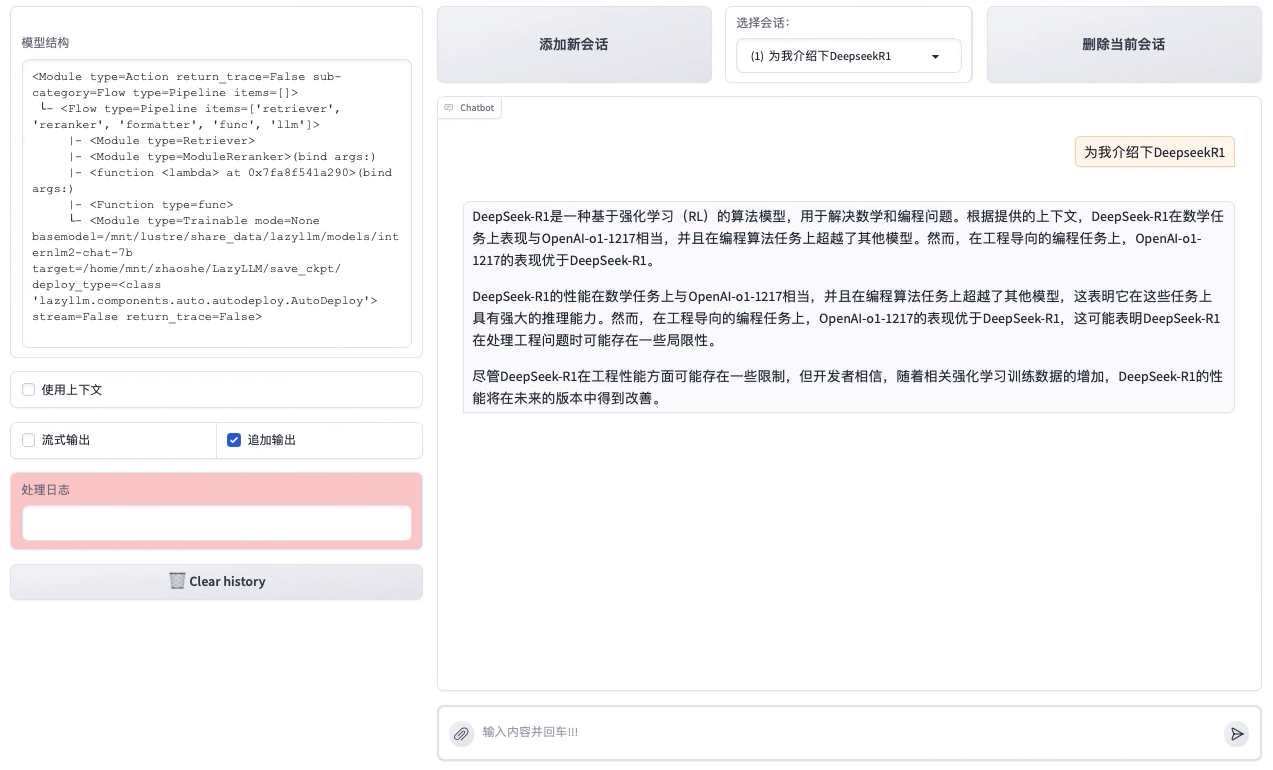
通过本系统，研究人员可以高效地获取论文信息，而无需逐字阅读整篇论文，大大提高了科研工作的便捷性和效率。

[相关视频：video\14_1.mp4](video/14_1.mp4)


# **朴素多模态RAG的论文系统**

多模态嵌入

方案一

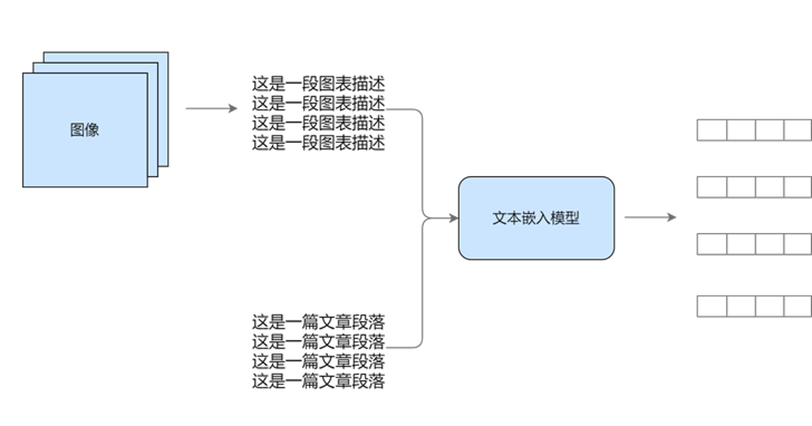

统一到文本模态，然后进行向量嵌入

方案二

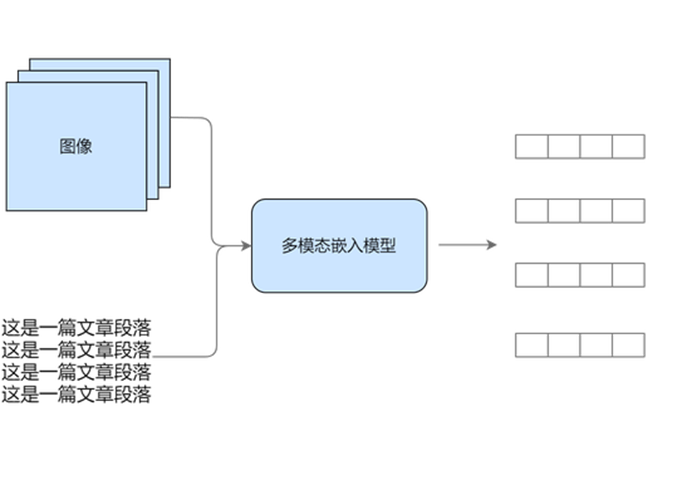

统一到向量空间：利用多模态模型进行映射

## 方案1：统一到文本模态

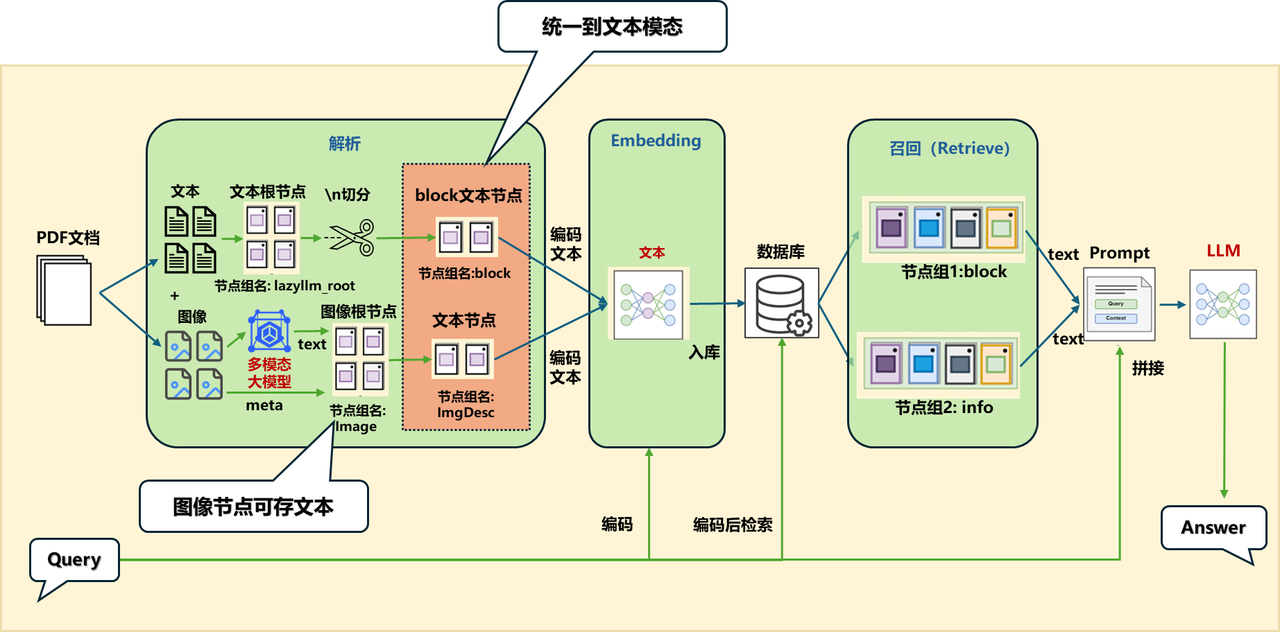

解析的过程构建ImageDocNode节点

In [ ]:
class MagicPDFReader(ReaderBase):
def __init__(self):
    self.image_save_path = get_image_path()
    self.model = None
    self.vlm = lazyllm.TrainableModule(‘internvl-chat-v1-5’).start()         # 初始化一个多模态大模型

def _result_extract(self, content_list):
    ......
    if not content["img_path"]:
        ......        block['img_desc'] = self.vlm(formatted_query(block["image_path"])) # 利用VLM对图像内容进行解析生成图像的文本描述

def _load_data(self, file: Path, split_documents: Optional[bool] = True, ) -> List[DocNode]:
     ......
     for k, v in element.items(): # 对其中的一个block
         ......
         if "text" in element:
               docs.append(DocNode(text=element["text"], metadata=metadata))
         elif "img_desc" in element:
               image_node = ImageDocNode(text=element["img_desc"], 
                                      image_path=element[“image_path”], global_metadata=metadata)# 构建ImageDocNode节点 
               docs.append(image_node)
         else:
               docs.append(DocNode(text="", metadata=metadata)) 

**应用编排实现**

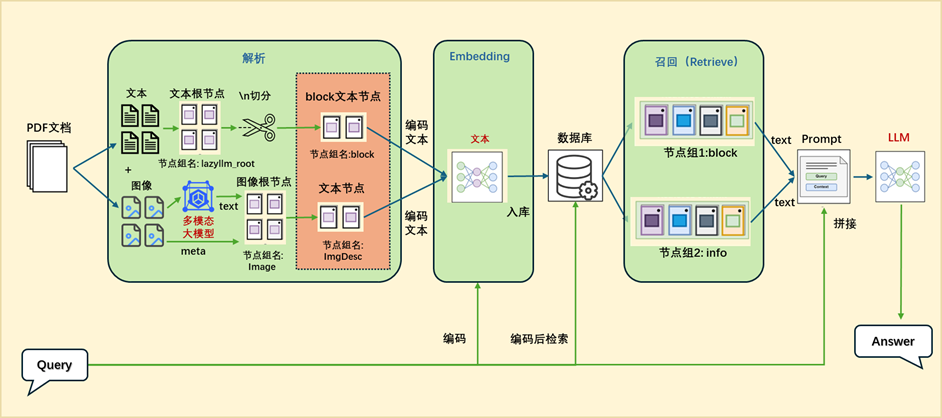

In [ ]:
    documents = lazyllm.Document(
        dataset_path=tmp_dir.rag_dir,
        embed=lazyllm.TrainableModule("bge-m3"),
        manager=False)
    documents.add_reader("*.pdf", MagicPDFReader)
    documents.create_node_group(name="block", transform=lambda s: s.split("\n") if s else '')
    with lazyllm.pipeline() as ppl:
        with lazyllm.parallel().sum as ppl.prl:
            ppl.prl.retriever1 = lazyllm.Retriever(documents, group_name="block", similarity="cosine", topk=1)
            ppl.prl.retriever2 = lazyllm.Retriever(documents, lazyllm.Document.ImgDesc, similarity="cosine", topk=1)
        ppl.prompt = build_vlm_prompt | bind(_0, ppl.input)
        ppl.vlm = lazyllm.OnlineChatModule()
    lazyllm.WebModule(ppl, port=range(23468, 23470), static_paths=get_image_path()).start().wait()

【效果展示】

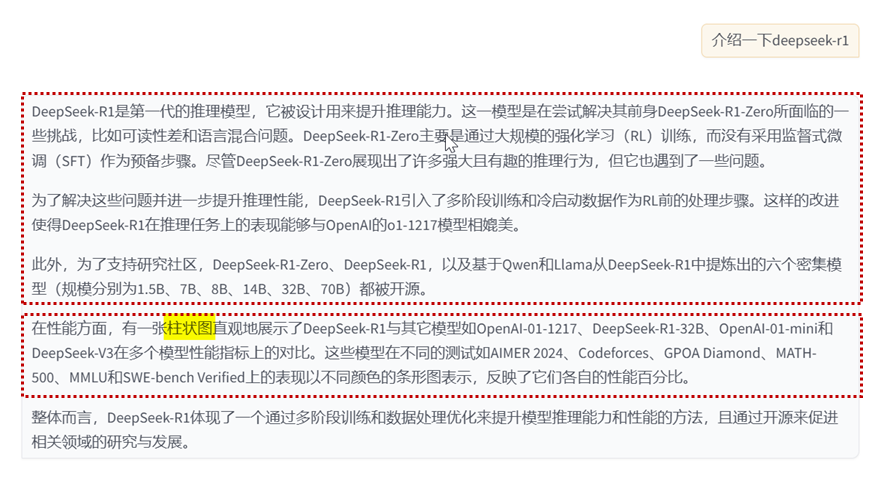

block节点组召回内容：

```bash
We introduce our frst-generation reasoning models, DeepSeek-R1-Zero and DeepSeek-R1. DeepSeek-R1-Zero, a model trained via large-scale reinforcement learning (RL) without supervised fne-tuning (SFT) as a preliminary step, demonstrates remarkable reasoning capabilities. Through RL, DeepSeek-R1-Zero naturally emerges with numerous powerful and intriguing reasoning behaviors. However, it encounters challenges such as poor readability, and language mixing. To address these issues and further enhance reasoning performance, we introduce DeepSeek-R1, which incorporates multi-stage training and cold-start data before RL. DeepSeekR1 achieves performance comparable to OpenAI-o1-1217 on reasoning tasks. To support the research community, we open-source DeepSeek-R1-Zero, DeepSeek-R1, and six dense models (1.5B, 7B, 8B, 14B, 32B, 70B) distilled from DeepSeek-R1 based on Qwen and Llama.
```

info节点组召回内容：

```bash
这张图片是一张柱状图，标题为“DeepSeek-R1 OpenAI-01-1217 DeepSeek-R1-32B OpenAI-01-mini DeepSeek-V3”。图表展示了六种不同模型的性能百分比，每种模型都以不同颜色的条形表示。
从左到右，第一列条形代表“AIMER 2024”模型，第二列代表“Codeforces”模型，第三列代表“GPOA Diamond”模型，第四列代表“MATH-500”模型，第五列代表“MMLU”模型，最后一列代表“SWE-bench Verified”模型。
每组条形都有五条，颜色分别为蓝色、灰色、橙色、黄色和紫色，分别对应不同的性能指标。
在图表下方，有五个百分比数值，分别对应每个模型的性能指标。这些数值以从左到右的顺序排列，与条形的颜色相对应。
整个图表以白色为背景，柱状图的颜色与背景形成对比，易于区分。
```

## 方案2：统一到向量空间

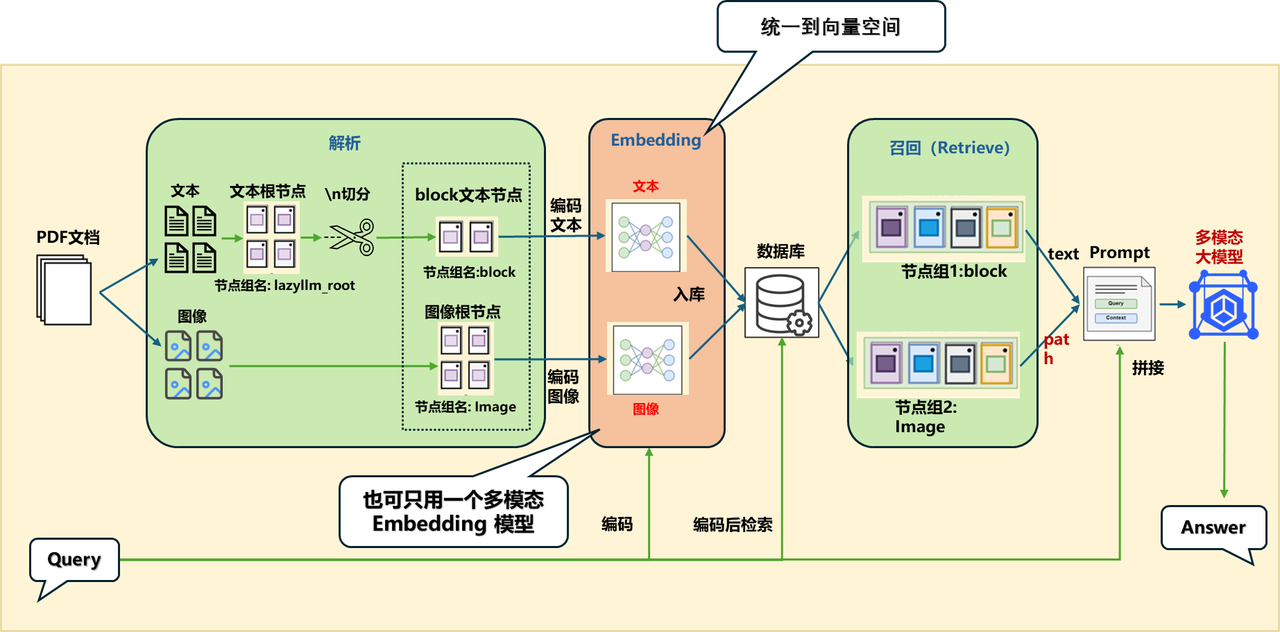

统一到向量空间，两种方案：

方案A：不同模态用对应的embedding:

-文本：用文本的embedding

-图像：用图像的embedding

方案B：用多模态embedding:

-图文都用同一个embedding

这里用了方案A，可以展示多embedding的使用。

**应用编排实现**

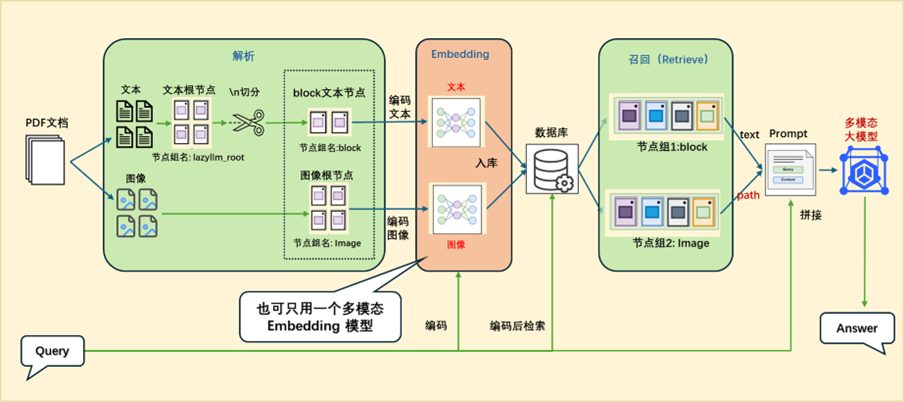

In [ ]:
embed_multimodal = lazyllm.TrainableModule("colqwen2-v0.1")
embed_text = lazyllm.OnlineEmbeddingModule(
    source='qwen', embed_model_name='text-embedding-v1')
embeds = {'vec1': embed_text, 'vec2': embed_multimodal}
documents = lazyllm.Document(
    dataset_path=tmp_dir.rag_dir, embed=embeds, manager=False)
documents.add_reader("*.pdf", MagicPDFReader)
documents.create_node_group(name="block", transform=lambda s: s.split("\n") if s else '')
with lazyllm.pipeline() as ppl:
    with lazyllm.parallel().sum as ppl.prl:
        ppl.prl.retriever1 = lazyllm.Retriever(documents, group_name="block", embed_keys=['vec1'], similarity="cosine", topk=1)
        ppl.prl.retriever2 = lazyllm.Retriever(documents, group_name="Image", embed_keys=['vec2'], similarity="maxsim", topk=2)
    ppl.prompt = build_vlm_prompt | bind(_0, ppl.input)
    ppl.vlm = lazyllm.OnlineChatModule(source="sensenova", model="SenseNova-V6-Turbo").prompt(lazyllm.ChatPrompter(gen_prompt))
lazyllm.WebModule(ppl, port=range(23468, 23470), static_paths=get_image_path()).start().wait()

【效果展示】

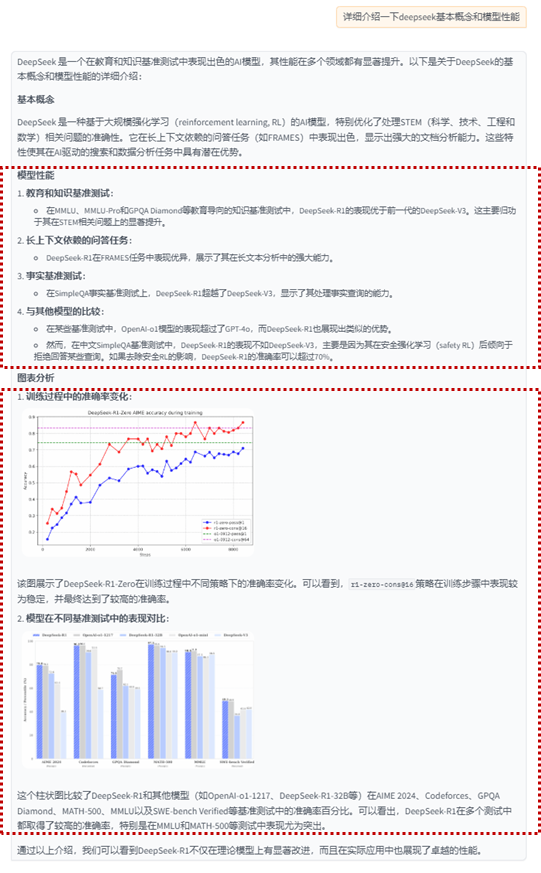

block节点组召回内容：

```bash
For education-oriented knowledge benchmarks such as MMLU, MMLU-Pro, and GPQA Diamond, DeepSeek-R1 demonstrates superior performance compared to DeepSeek-V3. This improvement is primarily attributed to enhanced accuracy in STEM-related questions, where significant gains are achieved through large-scale reinforcement learning. Additionally, DeepSeek-R1 excels on FRAMES, a long-context-dependent QA task, showcasing its strong document analysis capabilities. This highlights the potential of reasoning models in AI-driven search and data analysis tasks. On the factual benchmark SimpleQA, DeepSeek-R1 outperforms DeepSeek-V3, demonstrating its capability in handling fact-based queries. A similar trend is observed where OpenAI-o1 surpasses GPT-4o on this benchmark. However, DeepSeek-R1 performs worse than DeepSeek-V3 on the Chinese SimpleQA benchmark, primarily due to its tendency to refuse answering certain queries after safety RL. Without safety RL, DeepSeek-R1 could achieve an accuracy of over 70%.
```

image节点组召回内容：

```bash
/home/mnt/sunxiaoye/.lazyllm/rag_for_qa/images/c357bd57757e4c544fdda3ad32066e64c5d01bb8540066f1a722c8872d664183.jpg
/home/mnt/sunxiaoye/.lazyllm/rag_for_qa/images/2c6271b8cecc68d5b3c22e552f407a5e97d34030f91e15452c595bc8a76e291c.jpg
```

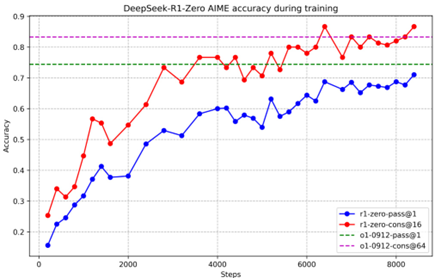

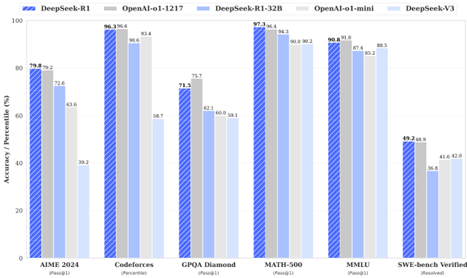


# **论文系统的效果优化**

## 改进方案

针对上述论文问答助手，我们还可以从以下几个角度进行优化：

- **优化0. 多路召回**  
  **问题**：由于不同类型的文档结构复杂、信息密度不同，单一的召回策略往往难以适应所有场景。  
  **解决方案**：并行多路召回  

- **优化1. 文本 QA 对总结提取**  
  **问题**：召回的文档往往包含大量冗余信息，直接传递给 LLM 可能会影响生成质量，导致回答不够精准或聚焦。  
  **解决方案**：预先使用 LLM 对解析后的文段进行处理，让 LLM 自动生成摘要标题和相关问题，并构造高质量的问答对（QA Pairs）和文档总结（Summary）。  

- **优化2. 图像 QA 对提取**  
  **问题**：纯文本的回答有时不能很好地解决用户的问题，与文本相比，很多图表更加清晰。  
  **解决方案**：  
  1. 利用多模态大模型对图像内容进行解析，生成图像的文字描述；  
  2. 将图像文字描述、路径等信息存储在 `ImageDocNode` 中；  
  3. 利用 Lazyllm 的 `LLM_Parse` 根据图像的文字描述生成 QA 对。  

- **优化3. PDF 转图化繁为简**  
  **问题**：PDF 解析过于复杂，代码功能设计繁琐。  
  **解决方案**：  
  1. 将 PDF 直接换行为图片；  
  2. 使用专门针对图文混合版式的多模态嵌入模型对其进行向量化；  
  3. 将和 query 匹配到的图像与 query 本身送给多模态大模型来做回答。  


## 优化1：+ 文本QA对 & Summary提取 方案

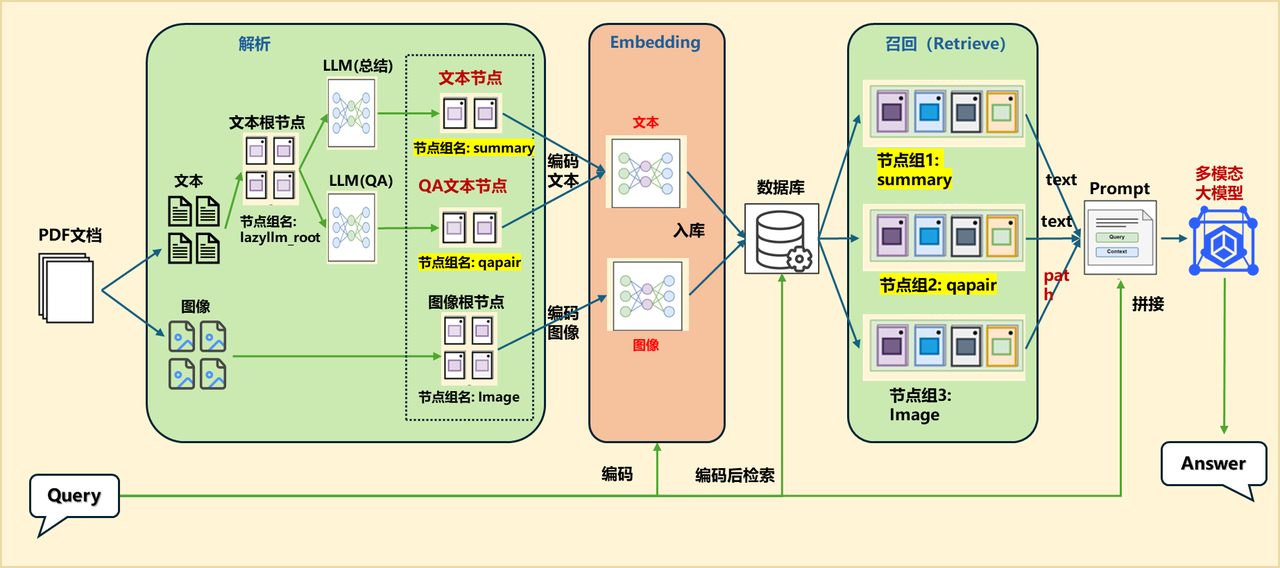

【应用编排】

In [ ]:
embed_mltimodal = lazyllm.TrainableModule("colqwen2-v0.1")
embed_text = lazyllm.TrainableModule("bge-m3")
embeds = {'vec1': embed_text, 'vec2': embed_mltimodal}
qapair_llm = lazyllm.LLMParser(lazyllm.OnlineChatModule(stream=False), language="zh", task_type="qa") 
summary_llm = lazyllm.LLMParser(lazyllm.OnlineChatModule(stream=False), language="zh", task_type="summary") 
documents = lazyllm.Document(dataset_path=tmp_dir.rag_dir, embed=embeds, manager=False)
documents.add_reader("*.pdf", MagicPDFReader)
documents.create_node_group(name="summary", transform=lambda d: summary_llm(d), trans_node=True)
documents.create_node_group(name='qapair', transform=lambda d: qapair_llm(d), trans_node=True)
with lazyllm.pipeline() as ppl:
    with lazyllm.parallel().sum as ppl.prl:
        ppl.prl.retriever1 = lazyllm.Retriever(documents, group_name="qapair", embed_keys=['vec1'], similarity="cosine", topk=1)
        ppl.prl.retriever2 = lazyllm.Retriever(documents, group_name="summary", embed_keys=['vec1'], similarity="cosine", topk=1)
        ppl.prl.retriever3 = lazyllm.Retriever(documents, group_name="Image", embed_keys=['vec2'], similarity="maxsim", topk=2)
    ppl.prompt = build_vlm_prompt | bind(_0, ppl.input)
    ppl.vlm = lazyllm.OnlineChatModule(source="sensenova", model="SenseNova-V6-Turbo").prompt(lazyllm.ChatPrompter(gen_prompt))
lazyllm.WebModule(ppl, port=range(23468, 23470), static_paths=get_image_path()).start().wait()

【效果展示】

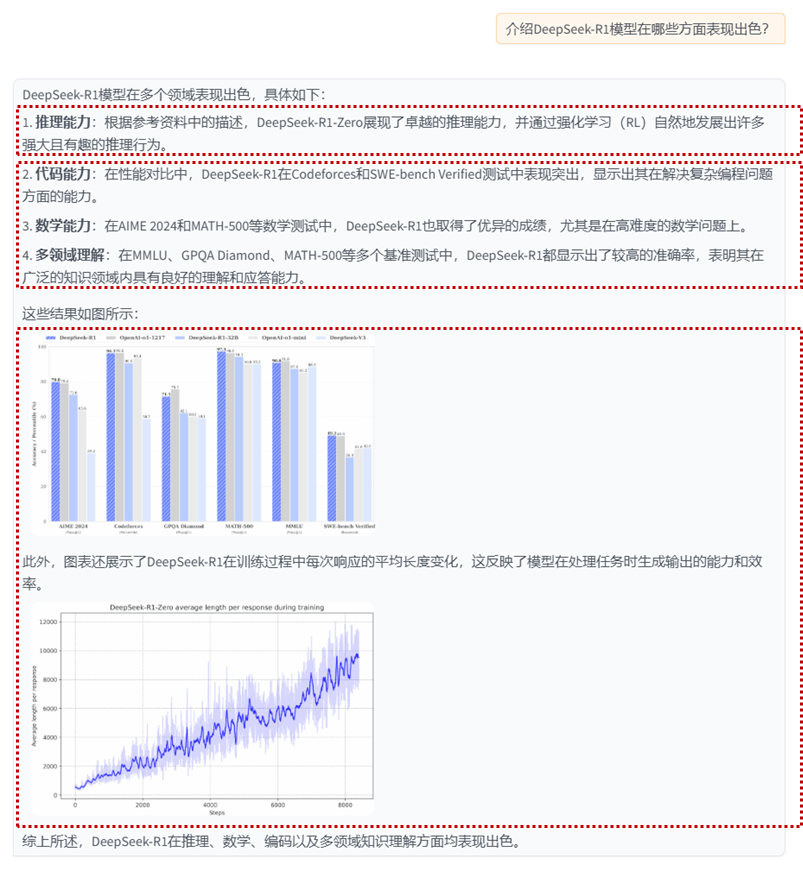

qapair节点组召回内容：

```bash
query:
What capabilities does DeepSeek-R1-Zero demonstrate?
answer
DeepSeek-R1-Zero demonstrates remarkable reasoning capabilities and naturally emerges with numerous powerful and intriguing reasoning behaviors through RL.
```

summary节点组召回内容：

```bash
性能对比表格摘要：
- 不同模型在多个基准测试中的表现，包括MMLU、MMLU-Redux、MMLU-Pro、DROP、IF-Eval、GPQA Diamond、SimpleQA、FRAMES、AlpacaEval2.0、ArenaHard等英语理解测试，以及LiveCodeBench、Codeforces、SWE Verified、Aider-Polyglot等代码能力测试和AIME、MATH-500、CNMO等数学能力测试。
- Claude-3.5-Sonnet-1022 0513、GPT-4o DeepSeek V3、OpenAI OpenAI 01-mini o1-1217、DeepSeek R1等模型在不同测试中各有优劣，例如DeepSeek R1在多数测试中表现优异，尤其在Codeforces和Aider-Polyglot中表现突出。
- 各模型在架构、激活参数、总参数和MMLU (Pass@1)等指标上的差异。
- 中文评估中，各模型在C-Eval和C-SimpleQA上的表现。
```

image节点组召回内容：

```bash
/path/to/images/2c6271b8cecc68d5b3c22e552f407a5e97d34030f91e15452c595bc8a76e291c.jpg
/path/to/ images/b671779ae926ef62c9a0136380a1116f31136c3fd1ed3fedc0e3e05b90925c20.jpg
```

## 优化2：+ 图片QA对 方案

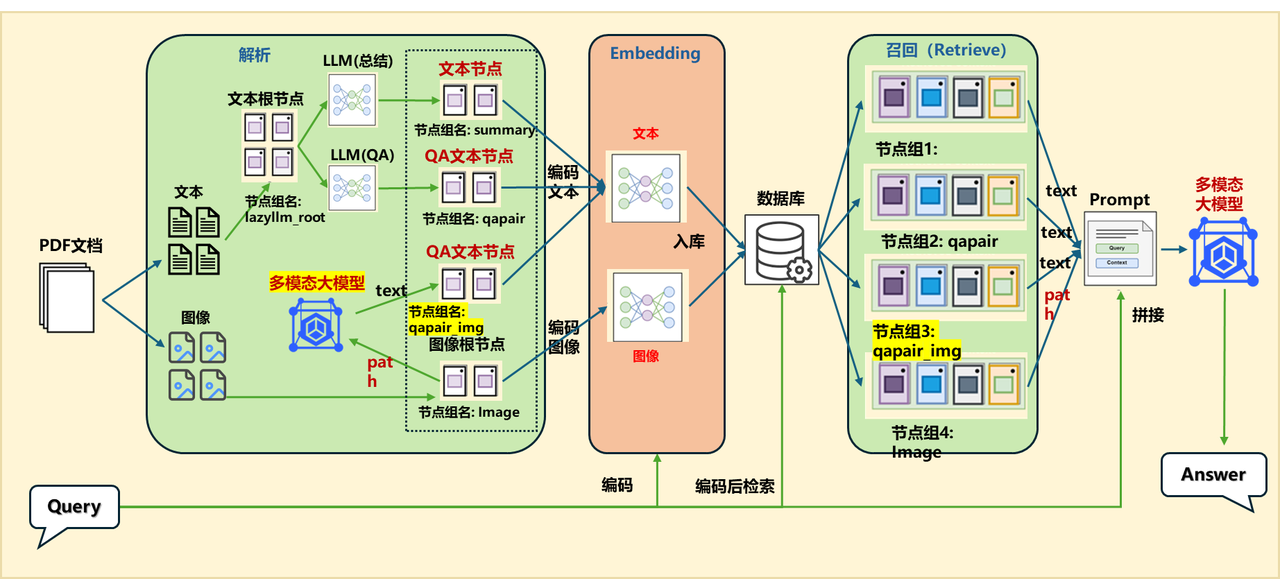

【应用编排】

In [ ]:
embed_mltimodal = lazyllm.TrainableModule("colqwen2-v0.1")
embed_text = lazyllm.TrainableModule("bge-m3")
embeds = {'vec1': embed_text, 'vec2': embed_mltimodal}
qapair_llm = lazyllm.LLMParser(lazyllm.OnlineChatModule(stream=False), language="zh", task_type="qa")
qapair_img_llm = lazyllm.LLMParser(
    lazyllm.OnlineChatModule(source="sensenova", model="SenseNova-V6-Turbo"), language="zh", task_type="qa_img") 
summary_llm = lazyllm.LLMParser(lazyllm.OnlineChatModule(stream=False), language="zh", task_type="summary") 
documents = lazyllm.Document(dataset_path=tmp_dir.rag_dir, embed=embeds, manager=False)
documents.add_reader("*.pdf", MagicPDFReader)
documents.create_node_group(name="summary", transform=lambda d: summary_llm(d), trans_node=True)
documents.create_node_group(name='qapair', transform=lambda d: qapair_llm(d), trans_node=True)
documents.create_node_group(name='qapair_img', transform=lambda d: qapair_img_llm(d), trans_node=True, parent='Image')
with lazyllm.pipeline() as ppl:
    with lazyllm.parallel().sum as ppl.prl:
        ppl.prl.retriever1 = lazyllm.Retriever(documents, group_name="summary", embed_keys=['vec1'], similarity="cosine", topk=1)
        ppl.prl.retriever2 = lazyllm.Retriever(documents, group_name="Image", embed_keys=['vec2'], similarity="maxsim", topk=2)
        ppl.prl.retriever3 = lazyllm.Retriever(documents, group_name="qapair", embed_keys=['vec1'], similarity="cosine", topk=1)
        ppl.prl.retriever4 = lazyllm.Retriever(documents, group_name="qapair_img", embed_keys=['vec1'], similarity="cosine", topk=1)
    ppl.prompt = build_vlm_prompt | bind(_0, ppl.input)
    ppl.vlm = lazyllm.OnlineChatModule(source="sensenova", model="SenseNova-V6-Turbo").prompt(lazyllm.ChatPrompter(gen_prompt))
lazyllm.WebModule(ppl, port=range(23468, 23470), static_paths=get_image_path()).start().wait()

【效果展示】

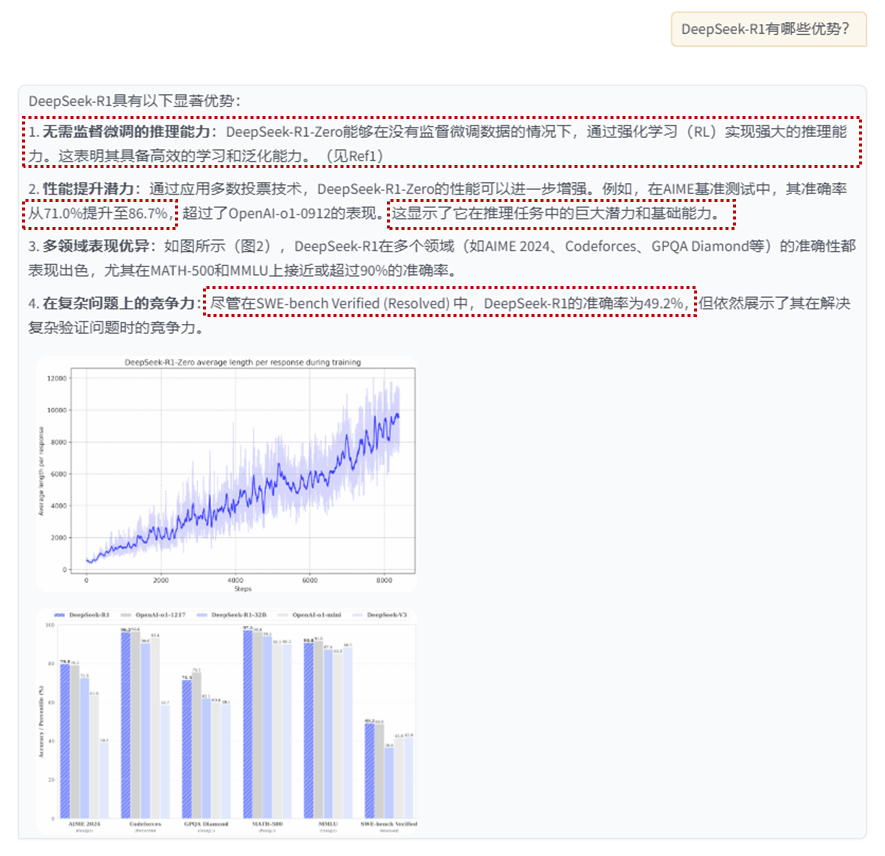

qapair节点组召回内容：

```bash
query:
DeepSeek-R1-Zero的性能表现说明了什么？
answer
DeepSeek-R1-Zero的性能表现突显了其强大的基础能力和在推理任务中进一步提升的潜力。
```

summary节点组召回内容：

```bash
DeepSeek-R1-Zero无需监督微调即可实现强大推理能力，通过仅使用强化学习展现出高效学习和泛化能力。应用多数投票可进一步提升其性能，如在AIME基准测试中，其性能从71.0%提升至86.7%，超越OpenAI-o1-0912。这表明DeepSeek-R1-Zero具备强大的基础能力，有潜力在推理任务中实现更多进展。
```

qapair_img 节点组召回内容：

```bash
query:
在SWE-bench Verified (Resolved) 中，DeepSeek-R1的准确率是多少？
answer
49.2%
```

image节点组召回内容：

```bash
/path/to/images/b671779ae926ef62c9a0136380a1116f31136c3fd1ed3fedc0e3e05b90925c20.jpg
(2) /path/to/images/2c6271b8cecc68d5b3c22e552f407a5e97d34030f91e15452c595bc8a76e291c.jpg
```

## 优化2：+ 图片QA对(变种) 方案

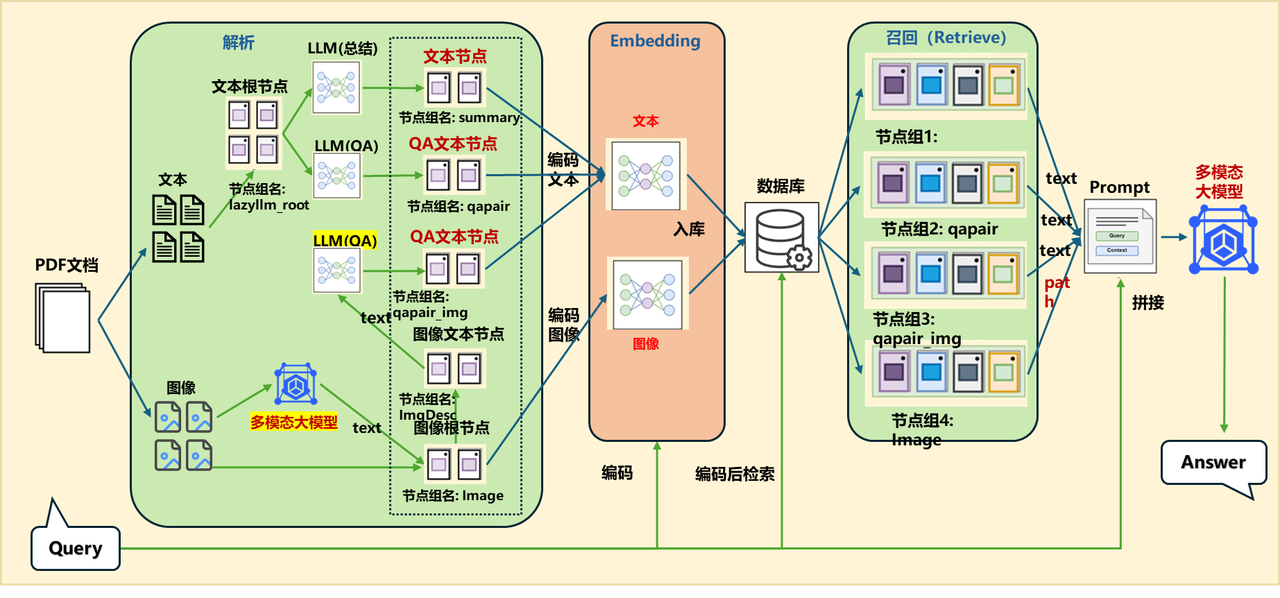

【应用编排（变种）】

In [ ]:
embed_mltimodal = lazyllm.TrainableModule("colqwen2-v0.1")
embed_text = lazyllm.TrainableModule("bge-m3")
embeds = {'vec1': embed_text, 'vec2': embed_mltimodal}
qapair_llm = lazyllm.LLMParser(lazyllm.OnlineChatModule(stream=False), language="zh", task_type="qa") 
summary_llm = lazyllm.LLMParser(lazyllm.OnlineChatModule(stream=False), language="zh", task_type="summary") 
documents = lazyllm.Document(dataset_path=tmp_dir.rag_dir, embed=embeds, manager=False)
documents.add_reader("*.pdf", MagicPDFReader)
documents.create_node_group(name="summary", transform=lambda d: summary_llm(d), trans_node=True)
documents.create_node_group(name='qapair', transform=lambda d: qapair_llm(d), trans_node=True)
documents.create_node_group(name='qapair_img', transform=lambda d: qapair_llm(d), trans_node=True, parent='ImgDesc')
with lazyllm.pipeline() as ppl:
    with lazyllm.parallel().sum as ppl.prl:
        ppl.prl.retriever1 = lazyllm.Retriever(documents, group_name="summary", embed_keys=['vec1'], similarity="cosine", topk=1)
        ppl.prl.retriever2 = lazyllm.Retriever(documents, group_name="Image", embed_keys=['vec2'], similarity="maxsim", topk=2)
        ppl.prl.retriever3 = lazyllm.Retriever(documents, group_name="qapair", embed_keys=['vec1'], similarity="cosine", topk=1)
        ppl.prl.retriever4 = lazyllm.Retriever(documents, group_name="qapair_img", embed_keys=['vec1'], similarity="cosine", topk=1)
    ppl.prompt = build_vlm_prompt | bind(_0, ppl.input)
    ppl.vlm = lazyllm.OnlineChatModule(source="sensenova", model="SenseNova-V6-Turbo").prompt(lazyllm.ChatPrompter(gen_prompt))
lazyllm.WebModule(ppl, port=range(23468, 23470), static_paths=get_image_path()).start().wait()

【效果展示1】

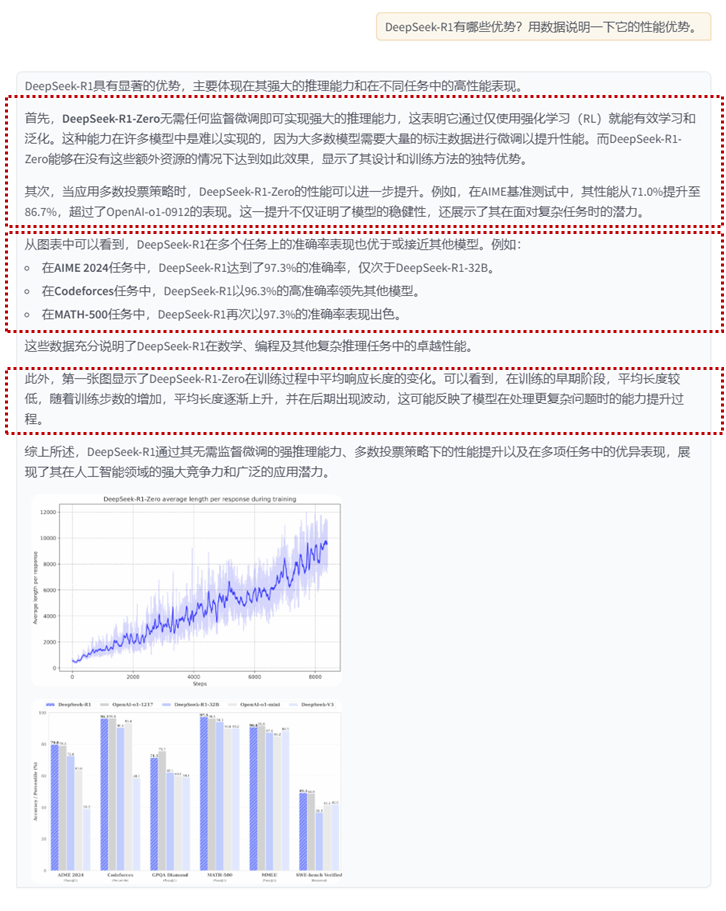

qapair节点组召回内容：

```bash
query:
DeepSeek-R1-Zero的性能表现说明了什么？
answer
DeepSeek-R1-Zero的性能表现突显了其强大的基础能力和在推理任务中进一步发展的潜力。
```

summary节点组召回内容：

```bash
DeepSeek-R1-Zero无需监督微调即可实现强推理能力，通过仅使用强化学习显示其有效学习和泛化能力。采用多数投票可进一步提升其性能，如在AIME基准测试中，性能从71.0%提升至86.7%，超过OpenAI-o1-0912。其有竞争力表现展示了强大的基础能力和在推理任务中进一步发展的潜力。
```

qapair_img 节点组召回内容：

```bash
query:
图表显示了DeepSeek-R1-Zero在训练过程中的平均长度如何变化？
answer
在训练的早期阶段，平均长度相对较低，随着步数的增加，平均长度逐渐上升，并在后期阶段出现波动。
```

image节点组召回内容：

```bash
/path/to/images/b671779ae926ef62c9a0136380a1116f31136c3fd1ed3fedc0e3e05b90925c20.jpg
/path/to/images/2c6271b8cecc68d5b3c22e552f407a5e97d34030f91e15452c595bc8a76e291c.jpg
```

【效果展示2——图像QA细节展示】

从PDF中解析出的原图像

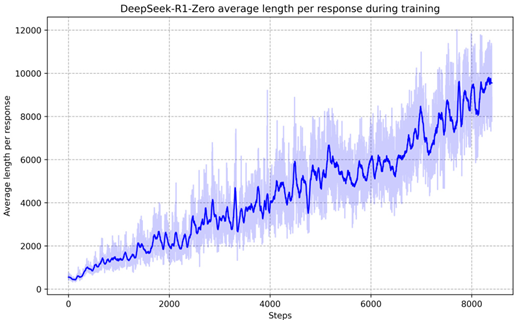

多模态大模型生成描述

```bash
这张图片展示了一个图表，该图表显示了DeepSeek-R1-Zero在训练过程中平均长度随步数增加而变化的趋势。图表中的蓝色线表示平均长度，而浅蓝色的阴影区域可能表示训练过程中的不确定性或误差范围。
在图表中，x轴代表步数，从0到大约8000，而y轴表示平均长度，从0到大约12000。图表显示，在训练的早期阶段，平均长度相对较低，随着步数的增加，平均长度逐渐上升，并在后期阶段出现波动。图表中的线条和阴影区域显示了训练过程中的变化，可能反映了DeepSeek-R1-Zero在处理数据或任务时所遇到的复杂性和不确定性。
请注意，由于图表中没有明确标注x轴和y轴的具体单位，上述描述是基于图表的视觉呈现，并未提供具体的数值信息。
```

针对生成的描述利用LLM生成QA对

```bash
Q: 这张图片展示了一个图表，它显示了什么内容？
A: 这张图片展示了一个图表，该图表显示了DeepSeek-R1-Zero在训练过程中平均长度随步数增加而变化的趋势。

Q: 图表中的蓝色线表示什么？
A: 图表中的蓝色线表示平均长度。

Q: 图表中的浅蓝色阴影区域可能表示什么？
A: 浅蓝色的阴影区域可能表示训练过程中的不确定性或误差范围。

Q: 图表的x轴和y轴分别代表什么？
A: x轴代表步数，从0到大约8000，而y轴表示平均长度，从0到大约12000。
·
Q: 图表显示了DeepSeek-R1-Zero在训练过程中的平均长度如何变化？
A: 在训练的早期阶段，平均长度相对较低，随着步数的增加，平均长度逐渐上升，并在后期阶段出现波动。

Q: 图表中的线条和阴影区域可能反映了什么？
A: 线条和阴影区域可能反映了DeepSeek-R1-Zero在处理数据或任务时所遇到的复杂性和不确定性。

Q: 描述中是否提供了具体的数值信息？
A: 没有，描述中没有提供具体的数值信息，仅基于图表的视觉呈现。
```

最终问答效果

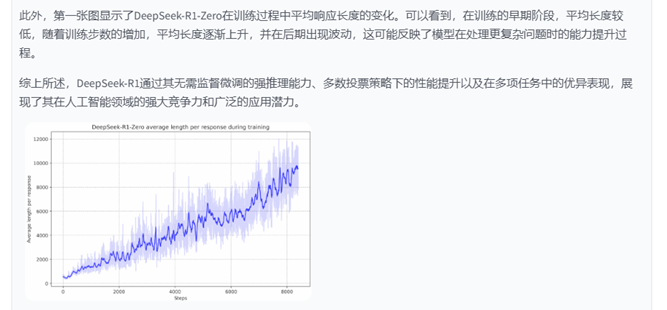


## 优化3：PDF转图化繁为简

- 传统方法：将文档结构化解析 → 图像 & 文本分别处理
- 新方向：将整页文档视为图像，使用多模态嵌入模型直接编码

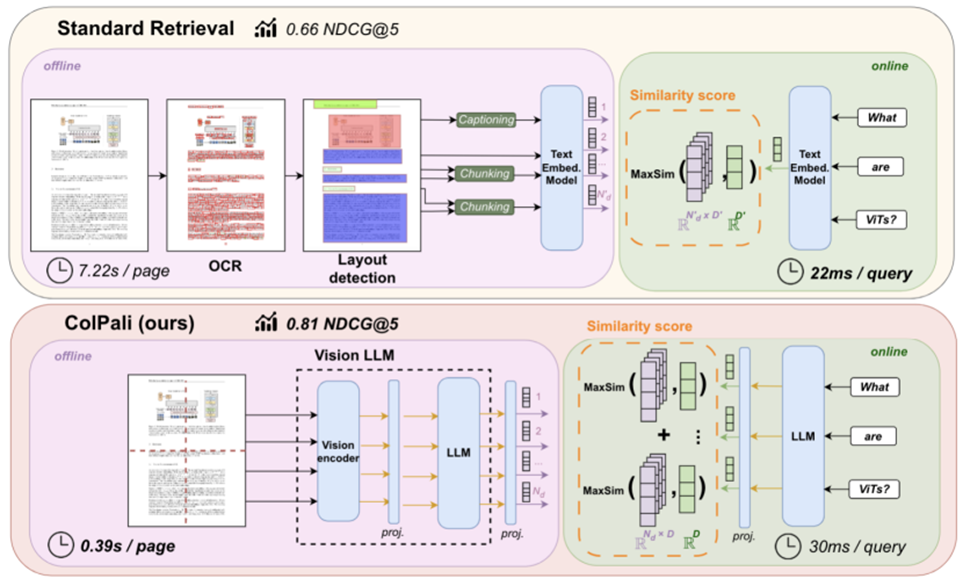

对于用户查询中的每一项目，ColPali 会识别出最相关的文档图像区域（被高亮显示的区域），并计算查询与页面之间的匹配分数。这里显示了“hour”和图像中的“Hours”及其时间高度相关。

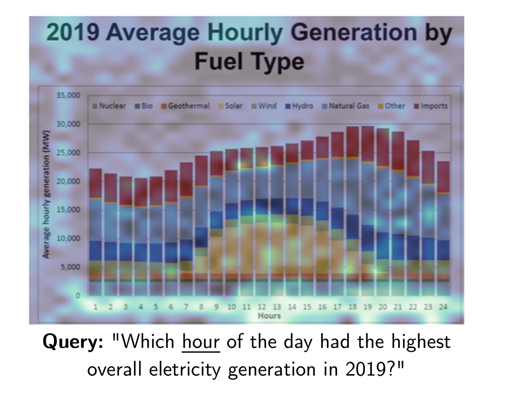

## 优化3：PDF转图化繁为简 LazyLLM方案

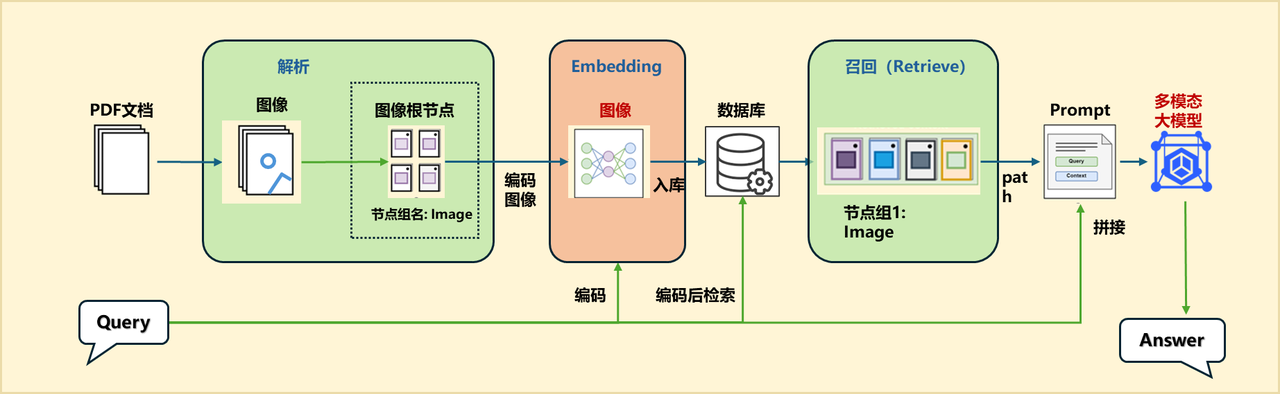
代码实现——PDF转图片

之前的方案中，文本解析阶段我们采用的是先解析文本、在构建节点的方式，流程相对复杂。这里直接将PDF解析为图像。供给后续多模态大模型使用（[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/a09a84cdf0585a5c9d52af6db0e965be95d03123/rag/codes/chapter14/PaperQA_MLM.py#L14C1-L14C35)）。

In [ ]:
# PDF转图像阅读器实现类
class Pdf2ImageReader(ReaderBase):
     def __init__(self, image_save_path="pdf_image_path"):
         super().__init__(); self.image_save_path = image_save_path
     if not os.path.exists(self.image_save_path): os.makedirs(self.image_save_path)

# PDF文件加载和转换核心方法
     def _load_data(self, file: Path, extra_info=None) -> List[ImageDocNode]:
         if not isinstance(file, Path): file = Path(file)
         docs = fitz.open(file); file_path = []
         for page_num in range(docs.page_count):
             metadata = extra_info or {}; metadata["file_name"] = file.name; metadata["file_split"] = page_num
            page = docs.load_page(page_num); pix = page.get_pixmap(dpi=300)
            img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
            save_path = f"{self.image_save_path}/{file.name[:-4]}_{page_num}.jpg"
            img.save(save_path); file_path.append(ImageDocNode(image_path=save_path, global_metadata=metadata))
     return file_path

通过上述代码，就可以通过 ImageDocNode.get_content()获取图像 PIL 对象，也可以通过 ImageDocNode.image_path 获取对应的存储路径，方便后续进行进一步的操作。

### 优化相似度计算方式——MaxSim相似度计算法

**MaxSim函数**是一种基于延迟交互的相似度计算方法，它通过将查询和文档的每个Token的向量进行逐对相似度计算，并追踪每对的最大得分来确定整体的相似度。

**核心原理**：

- 延迟交互机制：不直接计算全局相似度，而是逐Token交互后聚合
- 最大匹配策略：每个查询Token寻找文档中的最大响应值

下方是MaxSim函数的得分计算函数，我们只需实现相似度计算函数进行注册即可。MaxSim的具体公式如下:

$$S_{q,d}:=\Sigma_{i\in |E_q|}max_{j\in |E_d|}E_{q_i}·E_{d_j}^T$$

- $$E_q 是查询 q 的嵌入矩阵，每一行是一个 token 的向量。$$
- $$E_d 是文档 d 的嵌入矩阵，每一行是一个 token（或图像块）的向量。$$
- $$计算 E_{q_i} \cdot E_{d_j}^T （即点积），然后对 j 取最大值，得到每个查询 token 在文档中的最大匹配分数。$$
- $$最后对所有查询 token 的最大匹配分数求和，得到整体相似度得分 S_q,d。$$

接下来我们以一个简单的例子来说明 MaxSim 函数的计算过程。

假设我们有一个查询 q 和一个文档 d，它们的嵌入矩阵如下：

$$查询 q 的嵌入矩阵 E_q (假设每个 token 的嵌入维度为 3):$$

$$E_q = \begin{bmatrix} 0.5 &-0.2 \\0.3 &0.8 \end{bmatrix}$$

- $$查询有 2 个 token，因此 \lvert E_q \rvert = 2。$$

$$文档 d 的嵌入矩阵 E_d:$$

$$E_d = \begin{bmatrix} 0.1 & 0.1 \\ -0.3 & 0.6  \\ 0.7 &-0.5 \end{bmatrix}$$

$$文档有 3 个 token，因此 \lvert E_d \rvert = 3。$$

**计算步骤**

步骤1：通过点积运算（对应元素相乘后求和）：

• M11 = 0.5×0.1+(−0.2)×0.4=0.05−0.08=−0.03

• M12 = 0.5×(−0.3)+(−0.2)×0.6=−0.15−0.12=−0.27

• M13 = 0.5×0.7+(−0.2)×(−0.5)=0.35+0.10=0.45

• M21 = 0.3×0.1+0.8×0.4=0.03+0.32=0.35

• M22 = 0.3×(−0.3)+0.8×0.6=−0.09+0.48=0.39

• M23 = 0.3×0.7+0.8×(−0.5)=0.21−0.40=−0.19

$$E_d = \begin{bmatrix}-0.03 & -0.27&0.45 \\ 0.35 & 0.39&-0.19  \end{bmatrix}$$

步骤2：取每行最大值：

第一行最大值：max(−0.03,−0.27,0.45)=0.45

第二行最大值：max(0.35,0.39,−0.19)=0.39

**步骤3：全局求和** 最终相似度：*S*(*q*,*d*)=0.45+0.39=0.84

**结果**

- 查询 q 和文档 d 的最终相似度得分为 **0.84**。

**总结**

通过这个例子，我们可以看到 **MaxSim** 的计算过程：

1. 对每个查询 token，计算它与文档中所有 token 的点积（相似度）。
2. 对每个查询 token，取它与文档 token 的最大相似度。
3. 将所有查询 token 的最大相似度相加，得到最终的相似度得分。

其中S为查询q和文档d之间的最终相似度得分，Eq表示查询q的嵌入，Edi表示第i个图像块的嵌入。以下为MaxSim函数的代码实现（[GitHub链接](https://github.com/LazyAGI/Tutorial/blob/a09a84cdf0585a5c9d52af6db0e965be95d03123/rag/codes/chapter14/PaperQA_MLM.py#L43)）：

In [ ]:
import torch

@lazyllm.tools.rag.register_similarity(mode='embedding', batch=True)
def maxsim(query, nodes, **kwargs):
    batch_size = 128
    scores_list = []
    query = torch.Tensor([query for i in range(len(nodes))])
    nodes_embed = torch.Tensor(nodes)
    for i in range(0, len(query), batch_size):
        scores_batch = []
        query_batch = torch.nn.utils.rnn.pad_sequence(query[i : i + batch_size], batch_first=True, padding_value=0)
        for j in range(0, len(nodes_embed), batch_size):
            nodes_batch = torch.nn.utils.rnn.pad_sequence(nodes_embed[j : j + batch_size], batch_first=True, padding_value=0)
            scores_batch.append(torch.einsum("bnd,csd->bcns", query_batch, nodes_batch).max(dim=3)[0].sum(dim=2))
        scores_batch = torch.cat(scores_batch, dim=1).cpu()
        scores_list.append(scores_batch)
    scores = scores_list[0][0].tolist()
    return scores

【应用编排】

[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/a09a84cdf0585a5c9d52af6db0e965be95d03123/rag/codes/chapter14/PaperQA_MLM.py#L64C1-L64C33)

In [ ]:
# 定义将图像路径转换为markdown格式的函数
def format_markdown_image(text):
     json_part = text[text.index("{"):]; data = json.loads(json_part)
     image_paths = data.get("files", []); return f'\n\n![]({image_paths[0]})'
# 初始化文档处理模块并添加PDF阅读器
     image_file_path = "/content/images"
   documents = lazyllm.Document(dataset_path="/content/doc", 
                                   embed=lazyllm.TrainableModule("colqwen2-v0.1"))
     documents.add_reader("*.pdf", Pdf2ImageReader(image_file_path))
# 构建图像检索和处理流水线
     with pipeline() as ppl:
         ppl.retriever = Retriever(doc=documents, group_name="Image", similarity="maxsim", topk=1)
         ppl.formatter1 = lambda nodes : [node.image_path for node in nodes]
       ppl.formatter2 = encode_query_with_filepaths | bind(ppl.input, _0)
       with parallel().sum as ppl.prl:
            ppl.prl.vlm = lazyllm.OnlineChatModule(source="sensenova", model="SenseChat-Vision")
             ppl.prl.post_action = format_markdown_image# 启动Web服务
 lazyllm.WebModule(ppl, static_paths=image_file_path).start().wait()

【效果展示】

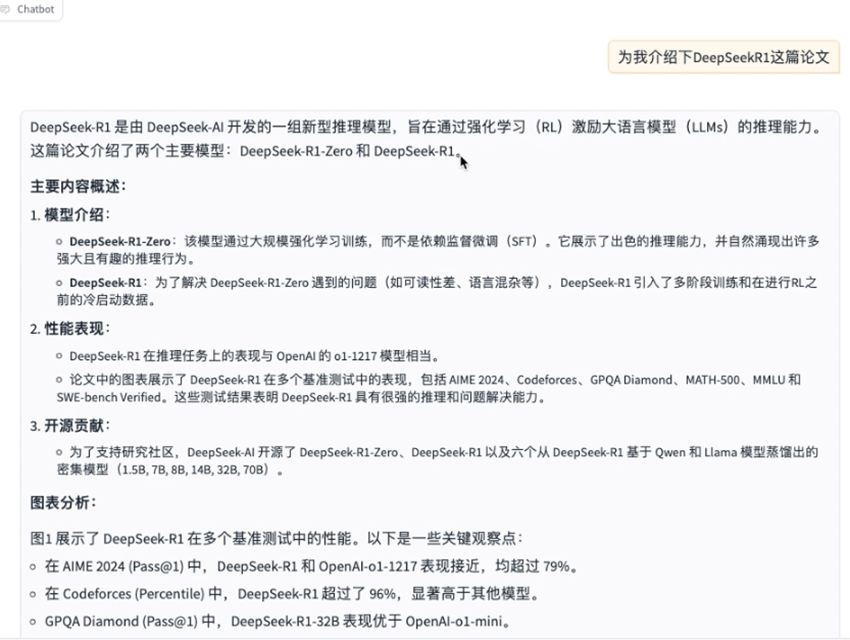

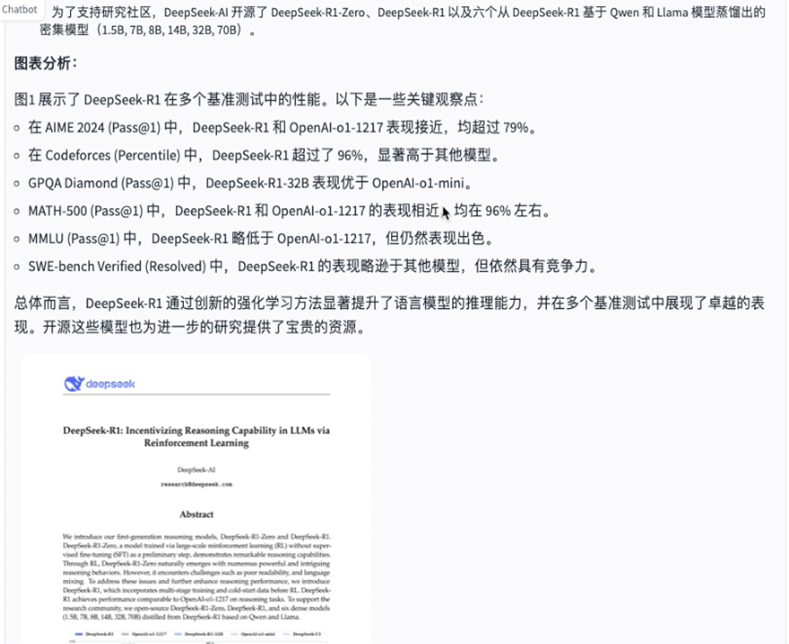

# **论文系统综合方案**

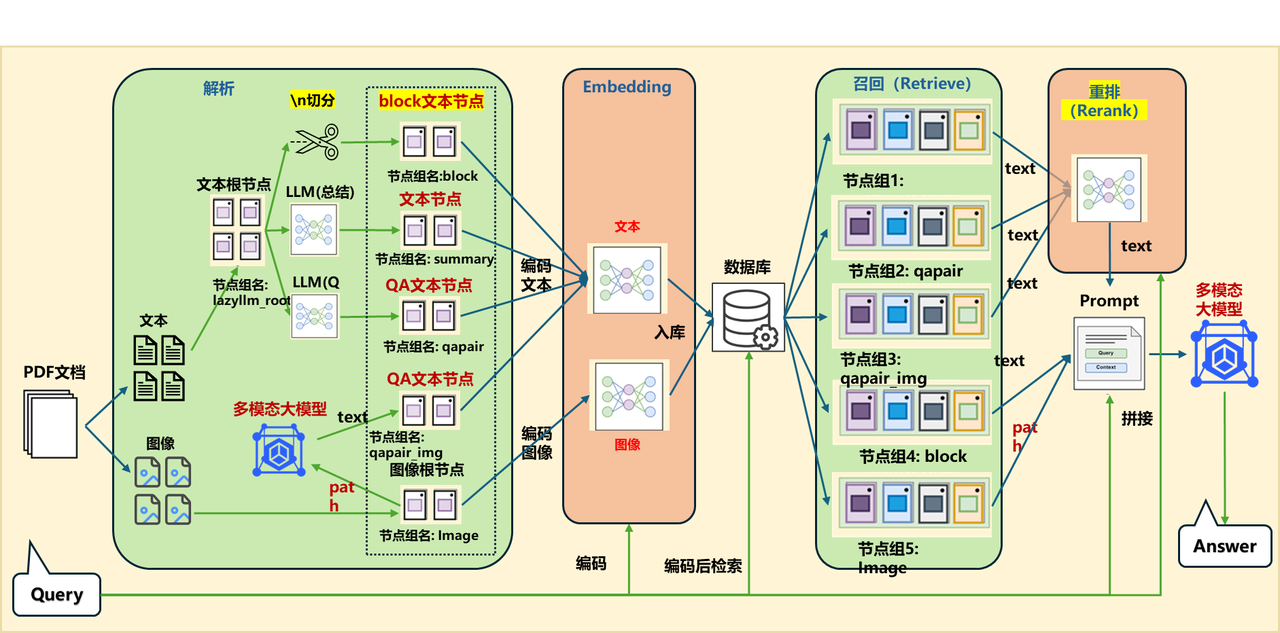

【应用编排】

In [ ]:
embed_mltimodal = lazyllm.TrainableModule("colqwen2-v0.1")
embed_text = lazyllm.TrainableModule("bge-m3")
embeds = {'vec1': embed_text, 'vec2': embed_mltimodal}
qapair_llm = lazyllm.LLMParser(lazyllm.OnlineChatModule(stream=False), language="zh", task_type="qa")
qapair_img_llm = lazyllm.LLMParser(
    lazyllm.OnlineChatModule(source="sensenova", model="SenseNova-V6-Turbo"), language="zh", task_type="qa_img") 
summary_llm = lazyllm.LLMParser(lazyllm.OnlineChatModule(stream=False), language="zh", task_type="summary") 
documents = lazyllm.Document(dataset_path=tmp_dir.rag_dir, embed=embeds, manager=False)
documents.add_reader("*.pdf", MagicPDFReader)
documents.create_node_group(name="block", transform=lambda s: s.split("\n") if s else '')
documents.create_node_group(name="summary", transform=lambda d: summary_llm(d), trans_node=True)
documents.create_node_group(name='qapair', transform=lambda d: qapair_llm(d), trans_node=True)
documents.create_node_group(name='qapair_img', transform=lambda d: qapair_img_llm(d), trans_node=True, parent='Image')
with lazyllm.pipeline() as ppl:
    with lazyllm.parallel().sum as ppl.mix:
        with lazyllm.pipeline() as ppl.mix.rank:
            with lazyllm.parallel().sum as ppl.mix.rank.short:
                ppl.mix.rank.short.retriever1 = lazyllm.Retriever(documents, group_name="summary", embed_keys=['vec1'], similarity="cosine", topk=4)
                ppl.mix.rank.short.retriever2 = lazyllm.Retriever(documents, group_name="qapair", embed_keys=['vec1'], similarity="cosine", topk=4)
                ppl.mix.rank.short.retriever3 = lazyllm.Retriever(documents, group_name="qapair_img", embed_keys=['vec1'], similarity="cosine", topk=4)
            ppl.mix.rank.reranker = lazyllm.Reranker("ModuleReranker", model="bge-reranker-large", topk=3) | bind(query=ppl.mix.rank.input)
        ppl.mix.retriever4 = lazyllm.Retriever(documents, group_name="block", embed_keys=['vec1'], similarity="cosine", topk=2)
        ppl.mix.retriever5 = lazyllm.Retriever(documents, group_name="Image", embed_keys=['vec2'], similarity="maxsim", topk=2)
    ppl.prompt = build_vlm_prompt | bind(_0, ppl.input)
    ppl.vlm = lazyllm.OnlineChatModule(source="sensenova", model="SenseNova-V6-Turbo").prompt(lazyllm.ChatPrompter(gen_prompt))
lazyllm.WebModule(ppl, port=range(23468, 23470), static_paths=get_image_path()).start().wait()

【效果展示】

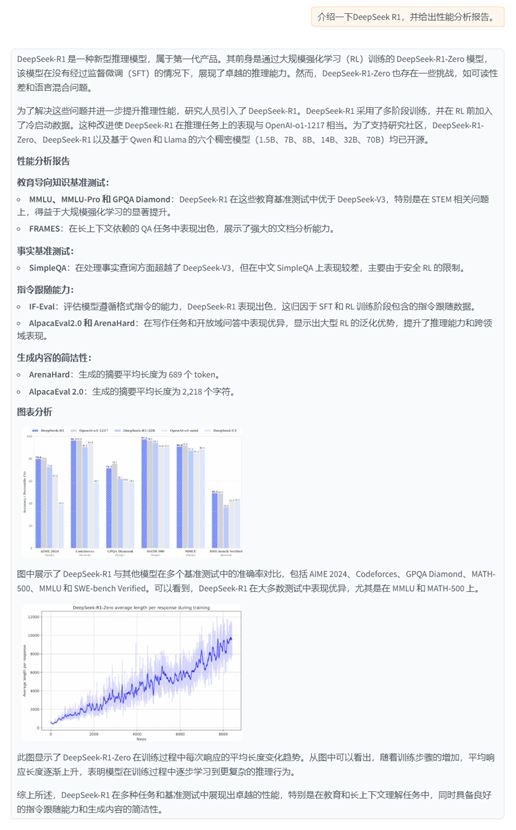

召回内容：

```bash
内容1：DeepSeek-R1 outperforms DeepSeek-V3 on education benchmarks and long-context QA, excelling in STEM and factual queries via reinforcement learning. However, it underperforms on Chinese SimpleQA due to safety RL restrictions.

内容2：DeepSeek-R1在IF-Eval、AlpacaEval2.0和ArenaHard上表现出色，得益于SFT和RL训练中包含的指令跟随数据。其优于DeepSeek-V3，展示了大型RL的泛化优势，提升推理能力和跨领域表现。生成的摘要长度平均为689个token（ArenaHard）和2218个字符（AlpacaEval2.0），表明其简洁性。

内容3：各模型在多种基准测试中的性能对比，包括MMLU、Codeforces、AIME等，显示不同模型在英语、代码和数学等领域的差异化表现。

内容4： We introduce our frst-generation reasoning models, DeepSeek-R1-Zero and DeepSeek-R1. DeepSeek-R1-Zero, a model trained via large-scale reinforcement learning (RL) without supervised fne-tuning (SFT) as a preliminary step, demonstrates remarkable reasoning capabilities. Through RL, DeepSeek-R1-Zero naturally emerges with numerous powerful and intriguing reasoning behaviors. However, it encounters challenges such as poor readability, and language mixing. To address these issues and further enhance reasoning performance, we introduce DeepSeek-R1, which incorporates multi-stage training and cold-start data before RL. DeepSeekR1 achieves performance comparable to OpenAI-o1-1217 on reasoning tasks. To support the research community, we open-source DeepSeek-R1-Zero, DeepSeek-R1, and six dense models (1.5B, 7B, 8B, 14B, 32B, 70B) distilled from DeepSeek-R1 based on Qwen and Llama.

内容5：|  | Benchmark (Metric) | Claude-3.5- Sonnet-1022 0513 | GPT-4o DeepSeek V3 |  | OpenAI OpenAI 01-mini o1-1217 | DeepSeek R1 |
```

Image 节点组召回内容：

```bash
/path/to/images/2c6271b8cecc68d5b3c22e552f407a5e97d34030f91e15452c595bc8a76e291c.jpg
/path/to/images/b671779ae926ef62c9a0136380a1116f31136c3fd1ed3fedc0e3e05b90925c20.jpg
```

## 总结拓展

在本节课程中，我们详细探讨了如何利用RAG（Retrieval-Augmented Generation）技术构建一个基于论文的问答系统。通过结合检索能力和大语言模型的生成能力，该系统能够帮助研究人员高效地从海量论文中提取核心信息，极大地提升了科研工作的效率。以下是本节内容的总结与拓展：

### 1. **系统架构与流程**

- **数据准备**：我们使用了arxivQA数据集中的论文，并通过自定义的PDF解析器（基于magic-pdf）对论文进行解析，提取文本、图片和表格等内容。
- **数据处理与组件搭建**：通过LazyLLM框架，我们构建了文档解析器、检索器、重排器（Reranker）和大模型（LLM）等核心组件，逐步实现了从文档解析到问答生成的完整流程。
- **效果展示与优化**：通过引入向量化检索和重排器，系统能够更精准地检索到与查询相关的论文段落，并结合大模型生成清晰、准确的回答。我们还通过QA文本对提取和多路召回等优化策略，进一步提升了系统的召回质量和生成效果。

### 2. **关键技术点**

- **自定义PDF解析器**：通过magic-pdf工具，我们实现了对PDF文档的深度解析，能够提取文本、图片和表格等结构化信息，并将其存储为DocNode对象，便于后续的检索和处理。
- **向量化检索与重排**：我们使用了BGE模型进行文本嵌入，并结合Milvus数据库进行向量化检索。通过引入重排器（Reranker），系统能够对检索结果进行精细化排序，确保最相关的内容排在最前面。
- **多模态整合**：在进阶优化中，我们探讨了如何将多模态大模型（如视觉模型）整合到RAG系统中，进一步提升系统对图表等非文本信息的理解能力。

### 3. **优化策略**

- **多路召回**：通过并行多路召回策略，系统能够结合多种检索方法（如基于关键词的稀疏检索和基于语义的密集检索），提高召回的全面性和鲁棒性。
- **QA文本对提取**：通过LLM生成高质量的问答对（QA Pairs），系统能够在召回阶段更精准地匹配用户查询，提升生成结果的相关性和准确性。
- **多模态协同处理**：通过整合多模态大模型，系统能够更好地处理论文中的图表信息，提供更全面的问答服务。
- **PDF转图化繁为简**：使用专门针对图文混合版式的多模态嵌入模型对转换为图的PDF文档进行向量化，省去了对PDF文档进行复杂解析和处理的逻辑，大大简化了开发工作。

### 4. **未来拓展方向**

- **多语言支持**：当前的系统主要针对中文和英文论文，未来可以扩展到支持更多语言的论文解析和问答。
- **更复杂的文档结构处理**：随着论文结构的多样化，系统可以进一步优化对复杂文档（如多级标题、交叉引用等）的处理能力。
- **实时更新与增量学习**：为了应对科研领域的快速变化，系统可以引入实时更新机制，支持对新论文的快速解析和知识库的增量更新。
- **用户个性化推荐**：通过分析用户的查询历史和研究兴趣，系统可以提供个性化的论文推荐和问答服务，进一步提升用户体验。

### 5. **总结**

通过本节课程的学习，我们不仅掌握了如何利用RAG技术构建一个高效的论文问答系统，还深入了解了如何通过优化策略提升系统的召回质量和生成效果。未来，随着多模态技术和增量学习等技术的进一步发展，RAG系统在科研领域的应用前景将更加广阔。

希望本节内容能够帮助大家更好地理解和应用RAG技术，期待大家在未来的科研工作中能够利用这些技术提升工作效率，取得更多的研究成果！